# Group Info

Team - 3 |
Usman Jadoon |
Hussein Mawaw |
Paola Dumbi |
Cole Brown |
Ingara Mayeke


***********************

Spring 2023 FINAL PROJECT |
GSU RCB Masters

***********************

Due Date: 04-24-2023


# Import Packages

In [ ]:
!pip install pyspark
!pip install textblob

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=6516040668c84f728211370eedcdfa15d5c069926babe653b0126dd97491a417
  Stored in directory: /root/.cache/pip/wheels/9f/34/a4/159aa12d0a510d5ff7c8f0220abbea42e5d81ecf588c4fd884
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.ml.feature import Tokenizer, HashingTF, IDF, StopWordsRemover
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, avg, count, sum, isnan, explode, first, last, split, asc, mean, lower, expr, lit, size, array, trim, regexp_replace, desc, collect_list, row_number, from_unixtime, udf
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import ClusteringEvaluator
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
import re
import requests
import json
import time
from wordcloud import WordCloud


# Create Spark Session and Google Colab Mount

In [ ]:
sc = SparkContext("local[*]")
spark = SparkSession(sc)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Data

In [ ]:
# Local Machine Import
# review_df = spark.read.csv( "/yelp_review.csv", header=True)
# business_df = spark.read.csv( "/yelp_business.csv", header=True)
# user_df = spark.read.csv( "/yelp_user.csv", header=True)

#Colab Import
review_df = spark.read.format("csv").option("header","true").option("multiline","true").load("/content/drive/MyDrive/yelp_review.csv")
business_df = spark.read.format("csv").option("header","true").option("multiline","true").load("/content/drive/MyDrive/yelp_business.csv")
user_df = spark.read.format("csv").option("header","true").option("multiline","true").load("/content/drive/MyDrive/yelp_user.csv")


# Cleaning

In [ ]:
# Column Rename / Column Datatype change

review_df = review_df.withColumn("Review_Stars", review_df["stars"].cast("double"))
review_df = review_df.withColumnRenamed("useful","review_useful")
review_df = review_df.withColumnRenamed("funny","review_funny")
review_df = review_df.withColumnRenamed("cool","review_cool")
business_df = business_df.withColumnRenamed("stars","Business_Stars")
business_df = business_df.withColumnRenamed("review_count","Business_review_count")
business_df = business_df.withColumnRenamed("name","business_name")
user_df = user_df.withColumnRenamed("name","user_name")
user_df = user_df.withColumnRenamed("useful","user_useful")
user_df = user_df.withColumnRenamed("funny","user_funny")
user_df = user_df.withColumnRenamed("cool","user_cool")
user_df = user_df.withColumnRenamed("review_count","user_review_count")

In [ ]:
# Only want ratings between 0 and 5
df_combined=review_df.join(business_df, ['business_id'])
df_combined = df_combined.drop("useful","funny","cool","stars","neighborhood","address","city","state","postal_code","is_open")
df_combined = df_combined.filter((col("Business_Stars") >= 0) & (col("Business_Stars") <= 5))
df_combined = df_combined.filter((col("Review_Stars") >= 0) & (col("Review_Stars") <= 5))


In [ ]:
# join user_df with business_review_df on user_id
user_review_df = user_df.join(df_combined, "user_id")

In [ ]:
#Converts categories to a list based on ;
df_combined = user_review_df.withColumn("category_list", split(user_review_df["categories"], ";"))

In [ ]:
df_combined.show()

+--------------------+-------------+-----------------+-------------+--------------------+-----------+----------+---------+----+--------------------+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+--------------------+--------------------+----------+--------------------+-------------+------------+-----------+------------+--------------------+-------------+--------------+--------------+---------------------+--------------------+--------------------+
|             user_id|    user_name|user_review_count|yelping_since|             friends|user_useful|user_funny|user_cool|fans|               elite|average_stars|compliment_hot|compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool|compliment_funny|compliment_writer|compliment_photos|         business_id|           review_id|      date

In [ ]:
df_combined.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- user_name: string (nullable = true)
 |-- user_review_count: string (nullable = true)
 |-- yelping_since: string (nullable = true)
 |-- friends: string (nullable = true)
 |-- user_useful: string (nullable = true)
 |-- user_funny: string (nullable = true)
 |-- user_cool: string (nullable = true)
 |-- fans: string (nullable = true)
 |-- elite: string (nullable = true)
 |-- average_stars: string (nullable = true)
 |-- compliment_hot: string (nullable = true)
 |-- compliment_more: string (nullable = true)
 |-- compliment_profile: string (nullable = true)
 |-- compliment_cute: string (nullable = true)
 |-- compliment_list: string (nullable = true)
 |-- compliment_note: string (nullable = true)
 |-- compliment_plain: string (nullable = true)
 |-- compliment_cool: string (nullable = true)
 |-- compliment_funny: string (nullable = true)
 |-- compliment_writer: string (nullable = true)
 |-- compliment_photos: string (nullable = true)
 |-- business

In [ ]:
# Assigns category a new row

df_combined_1 = df_combined \
    .select("user_id", "review_id","business_id" , "business_name" ,"elite","Business_Stars","text","review_useful","review_funny","review_cool","user_review_count","Business_review_count","user_useful","user_cool","user_funny",explode("category_list")\
            .alias("category"), "Review_Stars") \
    .groupBy("category", "user_id","review_id", "business_id" , "business_name", "elite","Business_Stars","text", "review_useful","review_funny","review_cool","user_review_count","Business_review_count","user_useful","user_cool","user_funny") \
    .agg(avg("Review_Stars").alias("avg_user_rating_category"))

In [ ]:
df_combined_1.show()

+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+-------------+------------+-----------+-----------------+---------------------+-----------+---------+----------+------------------------+
|         category|             user_id|           review_id|         business_id|       business_name|               elite|Business_Stars|                text|review_useful|review_funny|review_cool|user_review_count|Business_review_count|user_useful|user_cool|user_funny|avg_user_rating_category|
+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+-------------+------------+-----------+-----------------+---------------------+-----------+---------+----------+------------------------+
|       & Probates|FpzOJypuPLsAzZU2P...|oBFfBTXUpgD-iIpgA...|pZjqnVsar3roY3nsz...|"""Williams & Wil...|   

In [ ]:
# food grouping (6), beauty/spa grouping(4), hotels and travel(4)
cat_df = df_combined_1.filter((df_combined_1.category =="Pizza")|(df_combined_1.category =="Mexican")|
                              (df_combined_1.category =="Delis")|(df_combined_1.category =="Indian")|
                              (df_combined_1.category =="Mediterranean")|(df_combined_1.category =="Sushi Bars")|
                              (df_combined_1.category =="Tattoo")|(df_combined_1.category =="Massage")|
                              (df_combined_1.category =="Hair Salons")|(df_combined_1.category =="Barbers")|
                              (df_combined_1.category =="Resorts")|(df_combined_1.category =="Car Rental")|
                              (df_combined_1.category =="Casinos")|(df_combined_1.category =="Hotels"))


In [ ]:
cat_df.select('category').distinct().collect()

[Row(category='Mexican'),
 Row(category='Indian'),
 Row(category='Resorts'),
 Row(category='Barbers'),
 Row(category='Pizza'),
 Row(category='Car Rental'),
 Row(category='Sushi Bars'),
 Row(category='Tattoo'),
 Row(category='Casinos'),
 Row(category='Hotels'),
 Row(category='Delis'),
 Row(category='Mediterranean'),
 Row(category='Massage'),
 Row(category='Hair Salons')]

In [ ]:
# df_combined_final.show()
cat_df.show()

+-------------+--------------------+--------------------+--------------------+--------------------+-----+--------------+--------------------+--------------------+------------+-----------+-----------------+---------------------+-----------+---------+----------+------------------------+
|     category|             user_id|           review_id|         business_id|       business_name|elite|Business_Stars|                text|       review_useful|review_funny|review_cool|user_review_count|Business_review_count|user_useful|user_cool|user_funny|avg_user_rating_category|
+-------------+--------------------+--------------------+--------------------+--------------------+-----+--------------+--------------------+--------------------+------------+-----------+-----------------+---------------------+-----------+---------+----------+------------------------+
|      Resorts|--HeZYR8uZadRXLAQ...|Xz2TZVQqvCdSNyX9w...|_ZfjpSEO5ntk-1hbn...|   """Palms Place"""| None|           3.5|This was my first...| 

In [ ]:
#Limits the rows to top 1000
cat_df = cat_df.limit(800)

In [ ]:
cat_df.count()

800

# KMEANS

Building K-Means clustering model to predict User Reviews

In [ ]:
k_mean_df = df_combined_1
k_mean_df = k_mean_df.limit(15000)

In [ ]:
# assemble features vector
assembler = VectorAssembler(inputCols=["avg_user_rating_category"], outputCol="features", handleInvalid="skip")
user_ratings_features_df = assembler.transform(k_mean_df).select("user_id", "business_id" , "business_name" ,"category", "elite","Business_Stars","avg_user_rating_category" ,"text","features")


In [ ]:
user_ratings_features_df.show()

+--------------------+--------------------+--------------------+-----------------+--------------------+--------------+------------------------+--------------------+--------+
|             user_id|         business_id|       business_name|         category|               elite|Business_Stars|avg_user_rating_category|                text|features|
+--------------------+--------------------+--------------------+-----------------+--------------------+--------------+------------------------+--------------------+--------+
|FpzOJypuPLsAzZU2P...|pZjqnVsar3roY3nsz...|"""Williams & Wil...|       & Probates|                None|           5.0|                     5.0|I am beyond grate...|   [5.0]|
|XBcvglFglSloLRnSR...|cNs9Wpl1vf1hn6e58...|"""The Law Office...|       & Probates|                None|           4.0|                     5.0|Best attorney in ...|   [5.0]|
|Zy6KsVDIOy2CBTh1f...|xL-S6BfPkeMAe7myP...|"""Elizabeth A We...|       & Probates|                None|           5.0|            

In [ ]:
# n =15000 # Small Dataframe
n=user_ratings_features_df.count()
k_val = (n/2)**0.5
k_val=int(k_val)
k_val


######## USE ABOVE CODE IF YOU ARE LIMITING THE DATA USING CODE AT THE START, IT WILL BE SLOW IF YOU USE FULL DATA###########
############I have already calculated the values, its below you don't need to run code above for full dataset###############
# k_val1=2859
# k_val=86

86

In [ ]:
# cHECKS NULL VALUES
user_ratings_features_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in user_ratings_features_df.columns]).show()


+-------+-----------+-------------+--------+-----+--------------+------------------------+----+--------+
|user_id|business_id|business_name|category|elite|Business_Stars|avg_user_rating_category|text|features|
+-------+-----------+-------------+--------+-----+--------------+------------------------+----+--------+
|      0|          0|            0|       0|    0|             0|                       0|   0|       0|
+-------+-----------+-------------+--------+-----+--------------+------------------------+----+--------+



In [ ]:
# run k-means clustering
kmeans = KMeans(k=k_val, seed=1)
model = kmeans.fit(user_ratings_features_df)


In [ ]:
# get avg rating prediction for each user
k_pred = model.transform(user_ratings_features_df).select("user_id", "business_id" , "business_name" , "category", "elite","Business_Stars","avg_user_rating_category" ,"text","prediction", "features")

In [ ]:
k_pred.show()

+--------------------+--------------------+--------------------+-----------------+--------------------+--------------+------------------------+--------------------+----------+--------+
|             user_id|         business_id|       business_name|         category|               elite|Business_Stars|avg_user_rating_category|                text|prediction|features|
+--------------------+--------------------+--------------------+-----------------+--------------------+--------------+------------------------+--------------------+----------+--------+
|FpzOJypuPLsAzZU2P...|pZjqnVsar3roY3nsz...|"""Williams & Wil...|       & Probates|                None|           5.0|                     5.0|I am beyond grate...|         1|   [5.0]|
|XBcvglFglSloLRnSR...|cNs9Wpl1vf1hn6e58...|"""The Law Office...|       & Probates|                None|           4.0|                     5.0|Best attorney in ...|         1|   [5.0]|
|Zy6KsVDIOy2CBTh1f...|xL-S6BfPkeMAe7myP...|"""Elizabeth A We...|       & Pr

In [ ]:
k_pred.select('prediction').distinct().collect()

[Row(prediction=1),
 Row(prediction=4),
 Row(prediction=0),
 Row(prediction=2),
 Row(prediction=3)]

In [ ]:
# compute difference between actual vs predicted ratings
k_pred = k_pred.withColumn("diff_actual_vs_pred", k_pred["avg_user_rating_category"] - k_pred["prediction"])


In [ ]:
k_pred.show()

+--------------------+--------------------+--------------------+-----------------+--------------------+--------------+------------------------+--------------------+----------+--------+-------------------+
|             user_id|         business_id|       business_name|         category|               elite|Business_Stars|avg_user_rating_category|                text|prediction|features|diff_actual_vs_pred|
+--------------------+--------------------+--------------------+-----------------+--------------------+--------------+------------------------+--------------------+----------+--------+-------------------+
|FpzOJypuPLsAzZU2P...|pZjqnVsar3roY3nsz...|"""Williams & Wil...|       & Probates|                None|           5.0|                     5.0|I am beyond grate...|         1|   [5.0]|                4.0|
|XBcvglFglSloLRnSR...|cNs9Wpl1vf1hn6e58...|"""The Law Office...|       & Probates|                None|           4.0|                     5.0|Best attorney in ...|         1|   [5

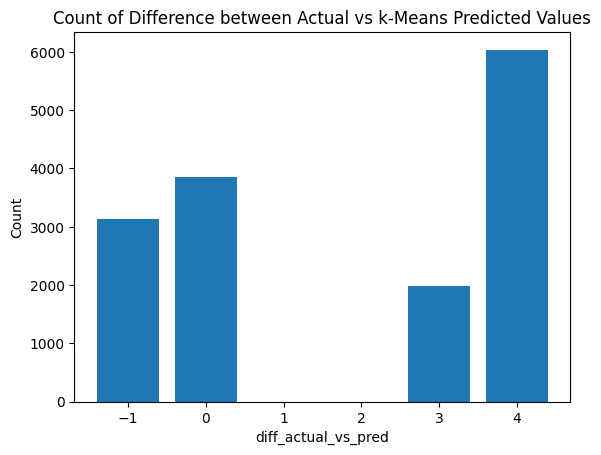

In [ ]:
# Count and group by diff_actual_vs_pred
k_mean_act_pred = k_pred.groupBy("diff_actual_vs_pred").count().collect()

# from pyspark to pandas df
k_means_counts_df = pd.DataFrame(k_mean_act_pred, columns=["diff_actual_vs_pred", "count"])

# plot the diff_actual_vs_pred counts as a bar graph
plt.bar(k_means_counts_df["diff_actual_vs_pred"], k_means_counts_df["count"])
plt.title("Count of Difference between Actual vs k-Means Predicted Values")
plt.xlabel("diff_actual_vs_pred")
plt.ylabel("Count")
plt.show()

In [ ]:
evaluator = ClusteringEvaluator()

# Compute SSE
sse = model.summary.trainingCost
print("Sum of Squared Errors (SSE): {:.2f}".format(sse))

# Compute Silhouette score
silhouette = evaluator.evaluate(k_pred)
print("Silhouette score: {:.2f}".format(silhouette))

Sum of Squared Errors (SSE): 0.00
Silhouette score: 1.00


SSE of 0 means that all data points are perfectly assigned to their respective clusters. Silhouette score of 1 means that all data points are well-clustered and are closer to their own cluster center than to other cluster centers.

----------------------------------------------------
The value i am getting with k = 3 is:

Sum of Squared Errors (SSE): 3014.951
Silhouette score: 0.741

these values are not good, so the formula to calculate k-value is working well

# Data Insights

In [ ]:
df_insights = df_combined_1

In [ ]:
# Avg Rating by Category and Business_name

avg_rat_by_category_and_buss = df_insights \
    .groupBy("category","business_name","business_id","Business_Stars") \
    .agg(avg("avg_user_rating_category").alias("Avg_rating"))\
    .orderBy("category", ascending=[True])



In [ ]:
avg_rat_by_category_and_buss.show()

+----------+--------------------+--------------------+--------------+------------------+
|  category|       business_name|         business_id|Business_Stars|        Avg_rating|
+----------+--------------------+--------------------+--------------+------------------+
|& Probates|"""The Law Office...|cNs9Wpl1vf1hn6e58...|           4.0|              4.25|
|& Probates|"""Elizabeth A We...|xL-S6BfPkeMAe7myP...|           5.0|               5.0|
|& Probates|"""Family First E...|193GRVErPSYgfMlq4...|           4.5| 4.636363636363637|
|& Probates|"""Beattie Ellen ...|X00bLb5dQcuaBvX9u...|           5.0|               5.0|
|& Probates|"""Arizona Notary...|Lt1rPwuTdOmMQSHx9...|           5.0|               5.0|
|& Probates|        """HP Law"""|tpeYS4RUOdXFLECsA...|           5.0|               5.0|
|& Probates|"""Platt & Westby"""|V2sX62YqJiolrr4Bq...|           4.5| 4.555555555555555|
|& Probates|"""Williams & Wil...|pZjqnVsar3roY3nsz...|           5.0|               5.0|
|& Probates|"""Nevada

In [ ]:
# Example: Apple and JCP reviews per listed category
avg_rat_by_category_and_buss.where(avg_rat_by_category_and_buss.business_name=='"""Apple Store"""').show()
avg_rat_by_category_and_buss.where(avg_rat_by_category_and_buss.business_name=='"""JCPenney"""').show()

+---------+-----------------+--------------------+--------------+------------------+
| category|    business_name|         business_id|Business_Stars|        Avg_rating|
+---------+-----------------+--------------------+--------------+------------------+
|Computers|"""Apple Store"""|N5mU4iB5jCy7B4re_...|           3.0|3.1825396825396823|
|Computers|"""Apple Store"""|eUI230JcFZLajIcDd...|           3.5| 3.727272727272727|
|Computers|"""Apple Store"""|R_syplGIQrqZc9DaA...|           3.5|3.4907975460122698|
|Computers|"""Apple Store"""|4zMxGvNBkxC3MopBD...|           3.5| 3.588235294117647|
|Computers|"""Apple Store"""|qESSv_hOQzziVNXvi...|           3.0|           3.15625|
|Computers|"""Apple Store"""|ES_4CV52Zm1Rw-fIB...|           3.5|3.6454545454545455|
|Computers|"""Apple Store"""|xvIKjbhFydKRzrnib...|           3.0|3.2145922746781115|
|Computers|"""Apple Store"""|qfj5Ih8-6RPF2ccvN...|           3.0|3.1433962264150943|
|Computers|"""Apple Store"""|s2tt75UaiI79V7H4C...|           3.5|

In [ ]:
# Average rating by Business

avg_rat_category_by_buss = df_insights \
    .groupBy("business_name","business_id","Business_Stars") \
    .agg(avg("avg_user_rating_category").alias("Avg_rating"))\
    .orderBy("business_name", ascending=[True])

In [ ]:
avg_rat_category_by_buss.show()

+--------------------+--------------------+--------------+------------------+
|       business_name|         business_id|Business_Stars|        Avg_rating|
+--------------------+--------------------+--------------+------------------+
|     """# 1 Nails"""|bXf05rPb8HVKRz62L...|           4.0| 4.132075471698113|
|"""#1 Cochran Bui...|7qi90SOzSjf3vfvXf...|           1.0|             1.125|
|"""#1 Cochran Bui...|OVcEKE97K2l3glHZ9...|           1.5|1.7142857142857142|
|"""#1 Cochran Cad...|IxzYgn2qvvP-6v2vs...|           3.5|               3.5|
|"""#1 Cochran Cad...|Z5kqhmXlKA_SDamQ5...|           4.5|               4.5|
|"""#1 Cochran Hyu...|tqEQd2LD0DeAqkE9t...|           3.5|              3.64|
|"""#1 Cochran Hyu...|1kHRZGYwMSLTxqN4D...|           3.5|3.7142857142857144|
|"""#1 Cochran Kia...|bTzhVdmvW5ynQgKkc...|           4.0| 4.095238095238095|
|"""#1 Cochran Maz...|GVSuvjB0Y-td4_Gx4...|           4.0|              3.75|
|"""#1 Cochran Maz...|YP-BWp7YkJtZnVOeO...|           4.0|      

In [ ]:
avg_rat_category_by_buss.where(avg_rat_category_by_buss.business_name=='"""Apple Store"""').show()
avg_rat_category_by_buss.where(avg_rat_category_by_buss.business_name=='"""JCPenney"""').show()

+-----------------+--------------------+--------------+------------------+
|    business_name|         business_id|Business_Stars|        Avg_rating|
+-----------------+--------------------+--------------+------------------+
|"""Apple Store"""|s2tt75UaiI79V7H4C...|           3.5|3.2857142857142856|
|"""Apple Store"""|xvIKjbhFydKRzrnib...|           3.0|3.2145922746781115|
|"""Apple Store"""|8nU1ykI-GTtiMGN-A...|           3.0|2.8181818181818183|
|"""Apple Store"""|6QJAT0N9X2dRqAtQy...|           3.0|2.9956896551724137|
|"""Apple Store"""|eUI230JcFZLajIcDd...|           3.5| 3.727272727272727|
|"""Apple Store"""|FAEO3WHP25djJsPDM...|           3.5|3.2983870967741935|
|"""Apple Store"""|rZiGxTgrDcoQrQjzz...|           4.0|               4.0|
|"""Apple Store"""|oLeNHOEqeuFFgDTpr...|           3.5| 3.272727272727273|
|"""Apple Store"""|EajCNl68Iqlm7dwu1...|           3.0| 3.027027027027027|
|"""Apple Store"""|_SMKHYIPOaV5tW1Yz...|           3.5|3.6153846153846154|
|"""Apple Store"""|zMm7sq

In [ ]:
# Average rating by Category

avg_rat_category_by_cat = df_insights \
    .groupBy("category") \
    .agg(avg("avg_user_rating_category").alias("Avg_rating"))\
    .orderBy("Avg_rating", ascending=[False])


In [ ]:
avg_rat_category_by_cat.show()

+--------------------+----------+
|            category|Avg_rating|
+--------------------+----------+
|Chinese Martial Arts|       5.0|
|         Bike Repair|       5.0|
|        Health Coach|       5.0|
|             Qi Gong|       5.0|
|              Tui Na|       5.0|
|        Trivia Hosts|       5.0|
|     Body Contouring|       5.0|
|Structural Engineers|       5.0|
|           Town Hall|       5.0|
|   Entertainment Law|       5.0|
|               Rodeo|       5.0|
|   Medical Foot Care|       5.0|
|Duplication Services|       5.0|
|Animal Assisted T...|       5.0|
|          Bus Rental|       5.0|
|Alternative Medicine|       5.0|
|     Process Servers|       5.0|
|  Storefront Clinics|       5.0|
|        Contract Law|       5.0|
|Undersea/Hyperbar...|       5.0|
+--------------------+----------+
only showing top 20 rows



In [ ]:
# Only Keeps Elites

elites = df_insights
elites = elites.filter(elites.elite != "None")


In [ ]:
elites.show()

+------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+-------------+------------+-----------+-----------------+---------------------+-----------+---------+----------+------------------------+
|    category|             user_id|           review_id|         business_id|       business_name|               elite|Business_Stars|                text|review_useful|review_funny|review_cool|user_review_count|Business_review_count|user_useful|user_cool|user_funny|avg_user_rating_category|
+------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+-------------+------------+-----------+-----------------+---------------------+-----------+---------+----------+------------------------+
|Cajun/Creole|oFyOUOeGTRZhFPF9u...|6SgvNWJltnZhW7duJ...|--9e1ONYQuAa-CB_R...|"""Delmonico Stea...|          2016, 2017|  

In [ ]:
# Average Elite rating for a business

avg_bus_rev_by_elite = elites \
    .groupBy("business_name") \
    .agg(avg("avg_user_rating_category").alias("Avg_rating"))\
    .orderBy("business_name", ascending=[True])

In [ ]:
avg_bus_rev_by_elite.show()

+--------------------+------------------+
|       business_name|        Avg_rating|
+--------------------+------------------+
|     """# 1 Nails"""|               5.0|
|"""#1 Cochran Bui...|               1.0|
|"""#1 Cochran Cad...|               3.0|
|"""#1 Cochran Hyu...|               2.5|
|"""#1 Cochran Hyu...|               5.0|
|"""#1 Cochran Kia...|               5.0|
|"""#1 Cochran Maz...|               2.0|
|"""#1 Cochran Maz...|               1.0|
|"""#1 Cochran Mon...|               3.0|
|"""#1 Cochran Nis...|              2.75|
|"""#1 Cochran Sub...|               4.5|
|"""#1 Cochran Vol...|               3.5|
| """#1 Fried Rice"""|               4.0|
|        """#1 Pho"""|              3.75|
|      """#1 Sushi"""| 4.166666666666667|
|"""$2.99 Cleaners"""|               3.0|
|   """$3 Car Wash"""|2.6666666666666665|
|"""&Company Resto...|2.6153846153846154|
|"""'1871' Berkele...|               4.0|
|"""'Round Table T...|               5.0|
+--------------------+------------

In [ ]:
avg_bus_rev_by_elite.where(avg_bus_rev_by_elite.business_name=='"""Apple Store"""').show()
avg_bus_rev_by_elite.where(avg_bus_rev_by_elite.business_name=='"""JCPenney"""').show()

+-----------------+-----------------+
|    business_name|       Avg_rating|
+-----------------+-----------------+
|"""Apple Store"""|3.672610556348074|
+-----------------+-----------------+

+--------------+-----------------+
| business_name|       Avg_rating|
+--------------+-----------------+
|"""JCPenney"""|3.376128385155466|
+--------------+-----------------+



In [ ]:
# Business stars for businesses in each category

category_business_stars_df = df_insights \
    .groupBy("category") \
    .agg(avg("Business_Stars").alias("Business_Stars"))\
    .orderBy("category", ascending=[True])

In [ ]:

category_business_stars_df.show()

+-------------------+--------------------+
|           category|      Business_Stars|
+-------------------+--------------------+
|         & Probates|   4.322916666666667|
|                  0|            0.052369|
|                  1|-0.28683664614942533|
|        3D Printing|  3.9423076923076925|
|  ATV Rentals/Tours|   4.501149425287356|
|         Acai Bowls|   3.932157394843962|
|        Accessories|  3.6584898778041217|
|        Accountants|  3.9084249084249083|
|     Acne Treatment|   4.114285714285714|
|        Active Life|  3.8977663658573065|
|        Acupuncture|   4.278036025566531|
| Addiction Medicine|  2.6948051948051948|
|  Adoption Services|  3.5555555555555554|
|              Adult|   4.164701547531319|
|    Adult Education|   3.227396021699819|
|Adult Entertainment|   3.358152222520347|
|        Advertising|   4.083460949464012|
|     Aerial Fitness|   4.149122807017544|
|       Aerial Tours|   4.974729241877256|
|             Afghan|   3.943696724988784|
+----------

In [ ]:
# compute difference between category user_rating and business_stars
df_insights = df_insights.withColumn("business_user_star_diff", df_insights["avg_user_rating_category"] - df_insights["Business_Stars"])


In [ ]:
df_insights.show()

+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+-------------+------------+-----------+-----------------+---------------------+-----------+---------+----------+------------------------+-----------------------+
|         category|             user_id|           review_id|         business_id|       business_name|               elite|Business_Stars|                text|review_useful|review_funny|review_cool|user_review_count|Business_review_count|user_useful|user_cool|user_funny|avg_user_rating_category|business_user_star_diff|
+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+-------------+------------+-----------+-----------------+---------------------+-----------+---------+----------+------------------------+-----------------------+
|       & Probates|FpzOJypuPLsAzZU

In [ ]:
# Gets top and bottom businesses based on different between user_review and business_stars

top_businesses_df = df_insights.groupBy("business_name").agg({"business_id": "first", "business_user_star_diff": "first"}).orderBy(["first(business_user_star_diff)"], ascending=[False])
bottom_businesses_df = df_insights.groupBy("business_name").agg({"business_id": "last", "business_user_star_diff": "last"}).orderBy(["last(business_user_star_diff)"], ascending=[True])

In [ ]:
top_businesses_df.show()

+--------------------+------------------------------+--------------------+
|       business_name|first(business_user_star_diff)|  first(business_id)|
+--------------------+------------------------------+--------------------+
|   """Angel Hotel"""|                     5.6139684|hsObd_dRmpxNGmXjw...|
|"""Station Tea Ro...|                      5.446601|l2M67j_7O0fOJiE28...|
|"""The Copper Hor...|                  5.4436502172|Absr2Yz1vKZgBvyOh...|
|       """jeremys"""|                      5.406636|y0m8WqajagGgZXnME...|
|"""Ask Restaurant...|                  5.3909482224|MrZP-KskDvvFvieam...|
|   """The Viceroy"""|                     4.9498749|PHb9AgEVXzuV4ETl3...|
|"""Paradise Park ...|                     4.9417385|ySvnHM-7yiql4p72h...|
|  """La Capilleta"""|                  4.6636947086|j6Pjn7vmWvQPIPHBi...|
|"""Whitby Pavilio...|                     4.6204872|hjUTVItTU5pb3rs2Y...|
|  """Hayburn Wyke"""|                     4.4481409|65lsX6xUM8zDG6YKo...|
|"""Bryherstones C...|   

In [ ]:
bottom_businesses_df.show()

+--------------------+-----------------------------+--------------------+
|       business_name|last(business_user_star_diff)|   last(business_id)|
+--------------------+-----------------------------+--------------------+
|"""Children's Den...|                         -4.0|PBAD1iyZ9wYS6T2lg...|
|"""Appliance Repa...|                         -4.0|XGmTssSCcKk7FEfyL...|
|"""Cyclone Las Ve...|                         -4.0|sT8mgh8MCgd-hCNis...|
|"""Busted Knuckle...|                         -4.0|JpBNnAZE3DDQHMp2m...|
|"""My Little Posy"""|                         -4.0|EDlGfPFcejyDvAOKp...|
|"""Lupita's Hot D...|                         -4.0|d6kfTFKpKJX93qAEP...|
|"""New Castle Rea...|                         -4.0|iZS5tNVaC3F7nbIma...|
|"""Matt's Barber ...|                         -4.0|FOv6fBk077sjMnGC2...|
|"""Specialty Carp...|                         -4.0|EDxuaN-bf5tr95FSL...|
|"""Natural Choice...|                         -4.0|xIBIg1aDILVY3hNu6...|
| """Streak Patrol"""|                

In [ ]:
# Group by Business_Stars and calculate the mean for each attribute
ratings_summary = df_insights.groupBy('business_id', 'business_name').agg(
    mean('review_useful').alias('mean_useful'),
    mean('review_funny').alias('mean_funny'),
    mean('review_cool').alias('mean_cool'),
    mean('Business_review_count').alias('mean_review_count')
)


In [ ]:
ratings_summary.show()

+--------------------+--------------------+-------------------+--------------------+-------------------+-----------------+
|         business_id|       business_name|        mean_useful|          mean_funny|          mean_cool|mean_review_count|
+--------------------+--------------------+-------------------+--------------------+-------------------+-----------------+
|1U-IYjEaNcu1xXJqv...|    """Stori Anne"""|0.23076923076923078|                 0.0|0.15384615384615385|             14.0|
|GyGkKlzi59Srf2L9Z...|"""American Costu...| 1.3611111111111112|  0.2777777777777778|               0.25|             40.0|
|OUtDX1RsaZDdsunjI...|"""Terriaco Suits...|              1.625|               0.375|              0.125|             10.0|
|eSaG2RWnxp7UuLGuU...|"""Vitaly Scherbo...|               1.72|                0.36| 0.7777777777777778|             29.0|
|AnNc37ZrSbnA-Ijch...|"""Xtreme Air Par...| 1.3076923076923077|               0.275|              0.225|             86.0|
|S-Hksc_Hh_dMEbi

# Tokenize (with cat_df)

In [ ]:
# list of stop words
stops = ['','the','and','to','a','i','was','of','is','for','in','it','we','that','my','they','this','with','on','but','have','at','are','were','had','so','as','be','just','there','our','place','if','from','get','their','when','out','me','your','time','will','an','here','got','has','you','what','or','can','some','by','also','because',"i've",'than','went','it.','he','&','her','2','too','goint','two']

In [ ]:
# Tokenizing elements in the text coumn
tokenizer = Tokenizer(outputCol="words")
tokenizer.setInputCol("text")
toks_df=tokenizer.transform(cat_df)

# Removing Stop words
stopword_remover = StopWordsRemover(inputCol="words", stopWords=stops, outputCol="filtered_words")
toks_df = stopword_remover.transform(toks_df)


# Remove spaces before and after words in the "filtered_words" column
toks_df = toks_df.withColumn("filtered_words", expr("TRANSFORM(filtered_words, word -> TRIM(word))"))

# # Creating key-value pairs of words
# toks_df = toks_df.withColumn("word_count",
#                    expr("TRANSFORM(filtered_words, word -> NAMED_STRUCT('word', word, 'count', 1))"))

# Category Specifc Data - Mapped to get Frquency

In [ ]:
# 45 min run time
# split each category into two seperate ones
############# mexican #############
###### 1 star
mex1_df = toks_df.select(['business_id','review_id','avg_user_rating_category','filtered_words']).where(
    (toks_df.category=='Mexican') & (toks_df.avg_user_rating_category== 1.0))

# flat map all values into a list (limited df)
filtered_list_reviews = mex1_df.select(col("filtered_words")).rdd.flatMap(lambda x: x[0]).collect()
rdd = sc.parallelize(filtered_list_reviews)
rdd1 = rdd.map(lambda x:(x,1))

# get counts and grab results
res = rdd1.reduceByKey(lambda x,y:x+y)
res_collect = res.collect()
mex1_top = (sorted(res_collect, key = lambda x:x[1],reverse = True)[:20])

# create pysprak df
columns = ('Word','Count')
mex1_wc = spark.createDataFrame(mex1_top,columns)

###### 5 star
mex5_df = toks_df.select(['business_id','review_id','avg_user_rating_category','filtered_words']).where(
    (toks_df.category=='Mexican') & (toks_df.avg_user_rating_category== 5.0))

# flat map all values into a list (limited df)
filtered_list_reviews = mex5_df.select(col("filtered_words")).rdd.flatMap(lambda x: x[0]).collect()
rdd = sc.parallelize(filtered_list_reviews)
rdd1 = rdd.map(lambda x:(x,1))

# get counts and grab results
res = rdd1.reduceByKey(lambda x,y:x+y)
res_collect = res.collect()
mex5_top = (sorted(res_collect, key = lambda x:x[1],reverse = True)[:20])

# create pysprak df
columns = ('Word','Count')
mex5_wc = spark.createDataFrame(mex5_top,columns)

############# indian #############
###### 1 star
ind1_df = toks_df.select(['business_id','review_id','avg_user_rating_category','filtered_words']).where(
    (toks_df.category=='Indian') & (toks_df.avg_user_rating_category== 1.0))
# flat map all values into a list (limited df)
filtered_list_reviews = ind1_df.select(col("filtered_words")).rdd.flatMap(lambda x: x[0]).collect()
rdd = sc.parallelize(filtered_list_reviews)
rdd1 = rdd.map(lambda x:(x,1))

# get counts and grab results
res = rdd1.reduceByKey(lambda x,y:x+y)
res_collect = res.collect()
ind1_top = (sorted(res_collect, key = lambda x:x[1],reverse = True)[:20])

# create pysprak df
columns = ('Word','Count')
ind1_wc = spark.createDataFrame(ind1_top,columns)

###### 5 star
ind5_df = toks_df.select(['business_id','review_id','avg_user_rating_category','filtered_words']).where(
    (toks_df.category=='Indian') & (toks_df.avg_user_rating_category== 5.0))
# flat map all values into a list (limited df)
filtered_list_reviews = ind5_df.select(col("filtered_words")).rdd.flatMap(lambda x: x[0]).collect()
rdd = sc.parallelize(filtered_list_reviews)
rdd1 = rdd.map(lambda x:(x,1))

# get counts and grab results
res = rdd1.reduceByKey(lambda x,y:x+y)
res_collect = res.collect()
ind5_top = (sorted(res_collect, key = lambda x:x[1],reverse = True)[:20])

# create pysprak df
columns = ('Word','Count')
ind5_wc = spark.createDataFrame(ind5_top,columns)

############# delis #############
####### 1 star
del1_df = toks_df.select(['business_id','review_id','avg_user_rating_category','filtered_words']).where(
    (toks_df.category=='Delis') & (toks_df.avg_user_rating_category== 1.0))
# flat map all values into a list (limited df)
filtered_list_reviews = del1_df.select(col("filtered_words")).rdd.flatMap(lambda x: x[0]).collect()
rdd = sc.parallelize(filtered_list_reviews)
rdd1 = rdd.map(lambda x:(x,1))

# get counts and grab results
res = rdd1.reduceByKey(lambda x,y:x+y)
res_collect = res.collect()
del1_top = (sorted(res_collect, key = lambda x:x[1],reverse = True)[:20])

# create pysprak df
columns = ('Word','Count')
del1_wc = spark.createDataFrame(del1_top,columns)

##### 5 star
del5_df = toks_df.select(['business_id','review_id','avg_user_rating_category','filtered_words']).where(
    (toks_df.category=='Delis') & (toks_df.avg_user_rating_category== 5.0))
# flat map all values into a list (limited df)
filtered_list_reviews = del5_df.select(col("filtered_words")).rdd.flatMap(lambda x: x[0]).collect()
rdd = sc.parallelize(filtered_list_reviews)
rdd1 = rdd.map(lambda x:(x,1))

# get counts and grab results
res = rdd1.reduceByKey(lambda x,y:x+y)
res_collect = res.collect()
del5_top = (sorted(res_collect, key = lambda x:x[1],reverse = True)[:20])

# create pysprak df
columns = ('Word','Count')
del5_wc = spark.createDataFrame(del5_top,columns)

############## pizza #############
##### 1 star
piz1_df = toks_df.select(['business_id','review_id','avg_user_rating_category','filtered_words']).where(
    (toks_df.category=='Pizza') & (toks_df.avg_user_rating_category== 1.0))
# flat map all values into a list (limited df)
filtered_list_reviews = piz1_df.select(col("filtered_words")).rdd.flatMap(lambda x: x[0]).collect()
rdd = sc.parallelize(filtered_list_reviews)
rdd1 = rdd.map(lambda x:(x,1))

# get counts and grab results
res = rdd1.reduceByKey(lambda x,y:x+y)
res_collect = res.collect()
piz1_top = (sorted(res_collect, key = lambda x:x[1],reverse = True)[:20])

# create pysprak df
columns = ('Word','Count')
piz1_wc = spark.createDataFrame(piz1_top,columns)

##### 5 star
piz5_df = toks_df.select(['business_id','review_id','avg_user_rating_category','filtered_words']).where(
    (toks_df.category=='Pizza') & (toks_df.avg_user_rating_category== 5.0))
# flat map all values into a list (limited df)
filtered_list_reviews = piz5_df.select(col("filtered_words")).rdd.flatMap(lambda x: x[0]).collect()
rdd = sc.parallelize(filtered_list_reviews)
rdd1 = rdd.map(lambda x:(x,1))

# get counts and grab results
res = rdd1.reduceByKey(lambda x,y:x+y)
res_collect = res.collect()
piz5_top = (sorted(res_collect, key = lambda x:x[1],reverse = True)[:20])

# create pysprak df
columns = ('Word','Count')
piz5_wc = spark.createDataFrame(piz5_top,columns)

############## mediterranean #############
##### 1 star
med1_df = toks_df.select(['business_id','review_id','avg_user_rating_category','filtered_words']).where(
    (toks_df.category=='Mediterranean') & (toks_df.avg_user_rating_category== 1.0))
# flat map all values into a list (limited df)
filtered_list_reviews = med1_df.select(col("filtered_words")).rdd.flatMap(lambda x: x[0]).collect()
rdd = sc.parallelize(filtered_list_reviews)
rdd1 = rdd.map(lambda x:(x,1))

# get counts and grab results
res = rdd1.reduceByKey(lambda x,y:x+y)
res_collect = res.collect()
med1_top = (sorted(res_collect, key = lambda x:x[1],reverse = True)[:20])

# create pysprak df
columns = ('Word','Count')
med1_wc = spark.createDataFrame(med1_top,columns)

##### 5 star
med5_df = toks_df.select(['business_id','review_id','avg_user_rating_category','filtered_words']).where(
    (toks_df.category=='Mediterranean') & (toks_df.avg_user_rating_category== 5.0))
# flat map all values into a list (limited df)
filtered_list_reviews = med5_df.select(col("filtered_words")).rdd.flatMap(lambda x: x[0]).collect()
rdd = sc.parallelize(filtered_list_reviews)
rdd1 = rdd.map(lambda x:(x,1))

# get counts and grab results
res = rdd1.reduceByKey(lambda x,y:x+y)
res_collect = res.collect()
med5_top = (sorted(res_collect, key = lambda x:x[1],reverse = True)[:20])

# create pysprak df
columns = ('Word','Count')
med5_wc = spark.createDataFrame(med5_top,columns)

############## sushi #############
##### 1 star
sus1_df = toks_df.select(['business_id','review_id','avg_user_rating_category','filtered_words']).where(
    (toks_df.category=='Sushi Bars') & (toks_df.avg_user_rating_category== 1.0))
# flat map all values into a list (limited df)
filtered_list_reviews = sus1_df.select(col("filtered_words")).rdd.flatMap(lambda x: x[0]).collect()
rdd = sc.parallelize(filtered_list_reviews)
rdd1 = rdd.map(lambda x:(x,1))

# get counts and grab results
res = rdd1.reduceByKey(lambda x,y:x+y)
res_collect = res.collect()
sus1_top = (sorted(res_collect, key = lambda x:x[1],reverse = True)[:20])

# create pysprak df
columns = ('Word','Count')
sus1_wc = spark.createDataFrame(sus1_top,columns)

##### 5 star
sus5_df = toks_df.select(['business_id','review_id','avg_user_rating_category','filtered_words']).where(
    (toks_df.category=='Sushi Bars') & (toks_df.avg_user_rating_category== 5.0))
# flat map all values into a list (limited df)
filtered_list_reviews = sus5_df.select(col("filtered_words")).rdd.flatMap(lambda x: x[0]).collect()
rdd = sc.parallelize(filtered_list_reviews)
rdd1 = rdd.map(lambda x:(x,1))

# get counts and grab results
res = rdd1.reduceByKey(lambda x,y:x+y)
res_collect = res.collect()
sus5_top = (sorted(res_collect, key = lambda x:x[1],reverse = True)[:20])

# create pysprak df
columns = ('Word','Count')
sus5_wc = spark.createDataFrame(sus5_top,columns)


In [ ]:
############## car rentals #############
##### 1 star
car1_df = toks_df.select(['business_id','review_id','avg_user_rating_category','filtered_words']).where(
    (toks_df.category=='Car Rental') & (toks_df.avg_user_rating_category== 1.0))
# flat map all values into a list (limited df)
filtered_list_reviews = car1_df.select(col("filtered_words")).rdd.flatMap(lambda x: x[0]).collect()
rdd = sc.parallelize(filtered_list_reviews)
rdd1 = rdd.map(lambda x:(x,1))

# get counts and grab results
res = rdd1.reduceByKey(lambda x,y:x+y)
res_collect = res.collect()
car1_top = (sorted(res_collect, key = lambda x:x[1],reverse = True)[:20])

# create pysprak df
columns = ('Word','Count')
car1_wc = spark.createDataFrame(car1_top,columns)

##### 5 star
car5_df = toks_df.select(['business_id','review_id','avg_user_rating_category','filtered_words']).where(
    (toks_df.category=='Car Rental') & (toks_df.avg_user_rating_category== 5.0))
# flat map all values into a list (limited df)
filtered_list_reviews = car5_df.select(col("filtered_words")).rdd.flatMap(lambda x: x[0]).collect()
rdd = sc.parallelize(filtered_list_reviews)
rdd1 = rdd.map(lambda x:(x,1))

# get counts and grab results
res = rdd1.reduceByKey(lambda x,y:x+y)
res_collect = res.collect()
car5_top = (sorted(res_collect, key = lambda x:x[1],reverse = True)[:20])

# create pysprak df
columns = ('Word','Count')
car5_wc = spark.createDataFrame(car5_top,columns)


############## casinos #############
##### 1 star
cas1_df = toks_df.select(['business_id','review_id','avg_user_rating_category','filtered_words']).where(
    (toks_df.category=='Casinos') & (toks_df.avg_user_rating_category== 1.0))
# flat map all values into a list (limited df)
filtered_list_reviews = cas1_df.select(col("filtered_words")).rdd.flatMap(lambda x: x[0]).collect()
rdd = sc.parallelize(filtered_list_reviews)
rdd1 = rdd.map(lambda x:(x,1))

# get counts and grab results
res = rdd1.reduceByKey(lambda x,y:x+y)
res_collect = res.collect()
cas1_top = (sorted(res_collect, key = lambda x:x[1],reverse = True)[:20])

# create pysprak df
columns = ('Word','Count')
cas1_wc = spark.createDataFrame(cas1_top,columns)

##### 5 star
cas5_df = toks_df.select(['business_id','review_id','avg_user_rating_category','filtered_words']).where(
    (toks_df.category=='Casinos') & (toks_df.avg_user_rating_category== 5.0))
# flat map all values into a list (limited df)
filtered_list_reviews = cas5_df.select(col("filtered_words")).rdd.flatMap(lambda x: x[0]).collect()
rdd = sc.parallelize(filtered_list_reviews)
rdd1 = rdd.map(lambda x:(x,1))

# get counts and grab results
res = rdd1.reduceByKey(lambda x,y:x+y)
res_collect = res.collect()
cas5_top = (sorted(res_collect, key = lambda x:x[1],reverse = True)[:20])

# create pysprak df
columns = ('Word','Count')
cas5_wc = spark.createDataFrame(cas5_top,columns)

############## hotels #############
##### 1 star
hot1_df = toks_df.select(['business_id','review_id','avg_user_rating_category','filtered_words']).where(
    (toks_df.category=='Hotels') & (toks_df.avg_user_rating_category== 1.0))
# flat map all values into a list (limited df)
filtered_list_reviews = hot1_df.select(col("filtered_words")).rdd.flatMap(lambda x: x[0]).collect()
rdd = sc.parallelize(filtered_list_reviews)
rdd1 = rdd.map(lambda x:(x,1))

# get counts and grab results
res = rdd1.reduceByKey(lambda x,y:x+y)
res_collect = res.collect()
hot1_top = (sorted(res_collect, key = lambda x:x[1],reverse = True)[:20])

# create pysprak df
columns = ('Word','Count')
hot1_wc = spark.createDataFrame(hot1_top,columns)

##### 5 star
hot5_df = toks_df.select(['business_id','review_id','avg_user_rating_category','filtered_words']).where(
    (toks_df.category=='Hotels') & (toks_df.avg_user_rating_category== 5.0))
# flat map all values into a list (limited df)
filtered_list_reviews = hot5_df.select(col("filtered_words")).rdd.flatMap(lambda x: x[0]).collect()
rdd = sc.parallelize(filtered_list_reviews)
rdd1 = rdd.map(lambda x:(x,1))

# get counts and grab results
res = rdd1.reduceByKey(lambda x,y:x+y)
res_collect = res.collect()
hot5_top = (sorted(res_collect, key = lambda x:x[1],reverse = True)[:20])

# create pysprak df
columns = ('Word','Count')
hot5_wc = spark.createDataFrame(hot5_top,columns)

In [ ]:
############## massage #############
##### 1 star
mas1_df = toks_df.select(['business_id','review_id','avg_user_rating_category','filtered_words']).where(
    (toks_df.category=='Massage') & (toks_df.avg_user_rating_category== 1.0))
# flat map all values into a list (limited df)
filtered_list_reviews = mas1_df.select(col("filtered_words")).rdd.flatMap(lambda x: x[0]).collect()
rdd = sc.parallelize(filtered_list_reviews)
rdd1 = rdd.map(lambda x:(x,1))

# get counts and grab results
res = rdd1.reduceByKey(lambda x,y:x+y)
res_collect = res.collect()
mas1_top = (sorted(res_collect, key = lambda x:x[1],reverse = True)[:20])

# create pysprak df
columns = ('Word','Count')
mas1_wc = spark.createDataFrame(mas1_top,columns)

##### 5 star
mas5_df = toks_df.select(['business_id','review_id','avg_user_rating_category','filtered_words']).where(
    (toks_df.category=='Massage') & (toks_df.avg_user_rating_category== 5.0))
# flat map all values into a list (limited df)
filtered_list_reviews = mas5_df.select(col("filtered_words")).rdd.flatMap(lambda x: x[0]).collect()
rdd = sc.parallelize(filtered_list_reviews)
rdd1 = rdd.map(lambda x:(x,1))

# get counts and grab results
res = rdd1.reduceByKey(lambda x,y:x+y)
res_collect = res.collect()
mas5_top = (sorted(res_collect, key = lambda x:x[1],reverse = True)[:20])

# create pysprak df
columns = ('Word','Count')
mas5_wc = spark.createDataFrame(mas5_top,columns)

############## barbers #############
##### 1 star
bar1_df = toks_df.select(['business_id','review_id','avg_user_rating_category','filtered_words']).where(
    (toks_df.category=='Barbers') & (toks_df.avg_user_rating_category== 1.0))
# flat map all values into a list (limited df)
filtered_list_reviews = bar1_df.select(col("filtered_words")).rdd.flatMap(lambda x: x[0]).collect()
rdd = sc.parallelize(filtered_list_reviews)
rdd1 = rdd.map(lambda x:(x,1))

# get counts and grab results
res = rdd1.reduceByKey(lambda x,y:x+y)
res_collect = res.collect()
bar1_top = (sorted(res_collect, key = lambda x:x[1],reverse = True)[:20])

columns = ('Word','Count')
bar1_wc = spark.createDataFrame(bar1_top,columns)

##### 5 star
bar5_df = toks_df.select(['business_id','review_id','avg_user_rating_category','filtered_words']).where(
    (toks_df.category=='Barbers') & (toks_df.avg_user_rating_category== 5.0))
# flat map all values into a list (limited df)
filtered_list_reviews = bar5_df.select(col("filtered_words")).rdd.flatMap(lambda x: x[0]).collect()
rdd = sc.parallelize(filtered_list_reviews)
rdd1 = rdd.map(lambda x:(x,1))

# get counts and grab results
res = rdd1.reduceByKey(lambda x,y:x+y)
res_collect = res.collect()
bar5_top = (sorted(res_collect, key = lambda x:x[1],reverse = True)[:20])

columns = ('Word','Count')
bar5_wc = spark.createDataFrame(bar5_top,columns)

############## hair salons #############
##### 1 star
sal1_df = toks_df.select(['business_id','review_id','avg_user_rating_category','filtered_words']).where(
    (toks_df.category=='Hair Salons') & (toks_df.avg_user_rating_category== 1.0))
# flat map all values into a list (limited df)
filtered_list_reviews = sal1_df.select(col("filtered_words")).rdd.flatMap(lambda x: x[0]).collect()
rdd = sc.parallelize(filtered_list_reviews)
rdd1 = rdd.map(lambda x:(x,1))

# get counts and grab results
res = rdd1.reduceByKey(lambda x,y:x+y)
res_collect = res.collect()
sal1_top = (sorted(res_collect, key = lambda x:x[1],reverse = True)[:20])

columns = ('Word','Count')
sal1_wc = spark.createDataFrame(sal1_top,columns)

##### 5 star
sal5_df = toks_df.select(['business_id','review_id','avg_user_rating_category','filtered_words']).where(
    (toks_df.category=='Hair Salons') & (toks_df.avg_user_rating_category== 5.0))
# flat map all values into a list (limited df)
filtered_list_reviews = sal5_df.select(col("filtered_words")).rdd.flatMap(lambda x: x[0]).collect()
rdd = sc.parallelize(filtered_list_reviews)
rdd1 = rdd.map(lambda x:(x,1))

# get counts and grab results
res = rdd1.reduceByKey(lambda x,y:x+y)
res_collect = res.collect()
sal5_top = (sorted(res_collect, key = lambda x:x[1],reverse = True)[:20])

# create pyspark dataframe
columns = ('Word','Count')
sal5_wc = spark.createDataFrame(sal5_top,columns)

############## tattoo #############
##### 1 star
tat1_df = toks_df.select(['business_id','review_id','avg_user_rating_category','filtered_words']).where(
    (toks_df.category=='Tattoo') & (toks_df.avg_user_rating_category== 1.0))
# flat map all values into a list (limited df)
filtered_list_reviews = tat1_df.select(col("filtered_words")).rdd.flatMap(lambda x: x[0]).collect()
rdd = sc.parallelize(filtered_list_reviews)
rdd1 = rdd.map(lambda x:(x,1))

# get counts and grab results
res = rdd1.reduceByKey(lambda x,y:x+y)
res_collect = res.collect()
tat1_top = (sorted(res_collect, key = lambda x:x[1],reverse = True)[:20])

# create pyspark dataframe
columns = ('Word','Count')
tat1_wc = spark.createDataFrame(tat1_top,columns)

##### 5 star
tat5_df = toks_df.select(['business_id','review_id','avg_user_rating_category','filtered_words']).where(
    (toks_df.category=='Tattoo') & (toks_df.avg_user_rating_category== 5.0))
# flat map all values into a list (limited df)
filtered_list_reviews = tat5_df.select(col("filtered_words")).rdd.flatMap(lambda x: x[0]).collect()
rdd = sc.parallelize(filtered_list_reviews)
rdd1 = rdd.map(lambda x:(x,1))

# get counts and grab results
res = rdd1.reduceByKey(lambda x,y:x+y)
res_collect = res.collect()
tat5_top = (sorted(res_collect, key = lambda x:x[1],reverse = True)[:20])

# create pyspark dataframe
columns = ('Word','Count')
tat5_wc = spark.createDataFrame(tat5_top,columns)

# Frequency DataFrames

Top Words in 1 Star Mexican Reviews:
+-------+-----+
|   Word|Count|
+-------+-----+
|    not|25905|
|   food|22395|
|     no|12283|
|   like|11402|
|    she| 9974|
|    one| 9667|
|  would| 8754|
|service| 8676|
|ordered| 8569|
|    all| 8415|
|     go| 8277|
|  never| 8222|
|   even| 8186|
|     up| 8060|
|  order| 7949|
|   very| 7802|
|     us| 7743|
|  about| 7711|
|   been| 7248|
|  after| 7119|
+-------+-----+



[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token')]

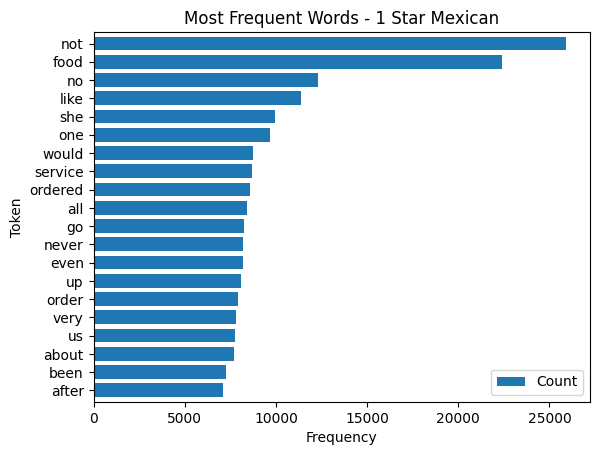

In [ ]:
print('Top Words in 1 Star Mexican Reviews:')
mex1_wc.show()

# Visualize most frequent words
mex1_pd = mex1_wc.toPandas()
barh_plot = mex1_pd.head(20).plot.barh(x = 'Word', y = 'Count',  width = 0.75, title = 'Most Frequent Words - 1 Star Mexican')
barh_plot.invert_yaxis() # Puts largest at top of y axis
barh_plot.set(xlabel = 'Frequency', ylabel = 'Token') # Adds labels



Top Words in 5 Star Mexican Reviews:
+----------+-----+
|      Word|Count|
+----------+-----+
|      food|48397|
|     great|39052|
|      very|29484|
|   mexican|27383|
|       not|25309|
|      good|24998|
|     tacos|24683|
|      best|23525|
|       all|22036|
|      love|19463|
|   service|19067|
|      it's|18536|
|       one|17624|
|      like|17559|
|    always|16677|
|        go|16389|
|    really|15800|
|      been|15676|
|      back|13966|
|definitely|13818|
+----------+-----+



[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token')]

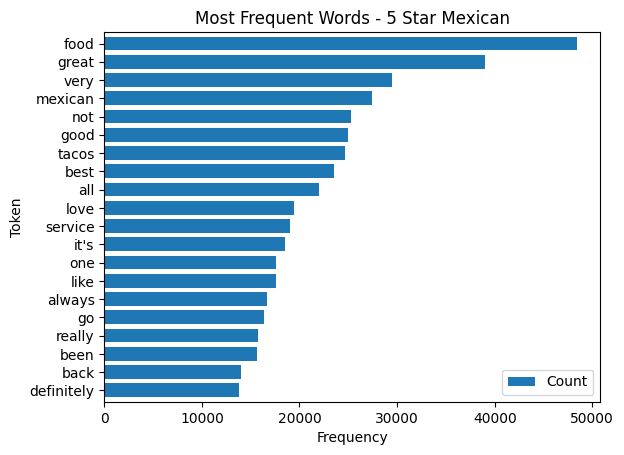

In [ ]:
print('Top Words in 5 Star Mexican Reviews:')
mex5_wc.show()

# Visualize most frequent words
mex5_pd = mex5_wc.toPandas()
barh_plot = mex5_pd.head(20).plot.barh(x = 'Word', y = 'Count',  width = 0.75, title = 'Most Frequent Words - 5 Star Mexican')
barh_plot.invert_yaxis() # Puts largest at top of y axis
barh_plot.set(xlabel = 'Frequency', ylabel = 'Token') # Adds labels

Top Words in 1 Star Indian Reviews:
+----------+-----+
|      Word|Count|
+----------+-----+
|      food| 4619|
|       not| 4280|
|    indian| 1992|
|   chicken| 1797|
|        no| 1605|
|      like| 1599|
|      very| 1598|
|       one| 1375|
|   ordered| 1359|
|restaurant| 1351|
|       all| 1293|
|      even| 1265|
|     would| 1246|
|        us| 1214|
|   service| 1194|
|     never| 1135|
|     after| 1131|
|     about| 1099|
|     order| 1096|
|        go| 1072|
+----------+-----+



[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token')]

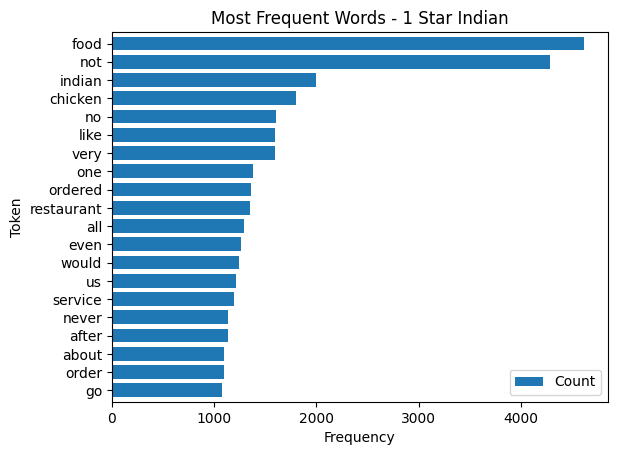

In [ ]:
print('Top Words in 1 Star Indian Reviews:')
ind1_wc.show()

# Visualize most frequent words
ind1_pd = ind1_wc.toPandas()
barh_plot = ind1_pd.head(20).plot.barh(x = 'Word', y = 'Count',  width = 0.75, title = 'Most Frequent Words - 1 Star Indian')
barh_plot.invert_yaxis() # Puts largest at top of y axis
barh_plot.set(xlabel = 'Frequency', ylabel = 'Token') # Adds labels

Top Words in 5 Star Indian Reviews:
+----------+-----+
|      Word|Count|
+----------+-----+
|      food|12580|
|    indian|10967|
|      very| 6845|
|   chicken| 6410|
|     great| 5703|
|       not| 5050|
|      best| 4805|
|      good| 4667|
|       all| 4260|
|   service| 3752|
|restaurant| 3742|
|      it's| 3429|
|      like| 3324|
|       one| 3298|
|    really| 3156|
|      been| 3122|
|        go| 3010|
|         -| 2810|
|    buffet| 2771|
|    always| 2750|
+----------+-----+



[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token')]

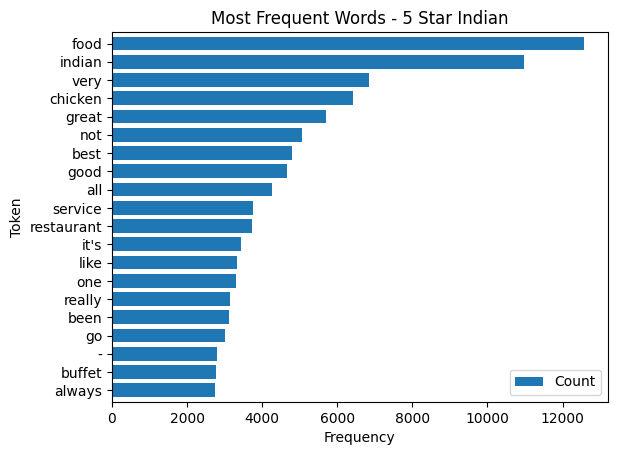

In [ ]:
print('Top Words in 5 Star Indian Reviews:')
ind5_wc.show()

# Visualize most frequent words
ind5_pd = ind5_wc.toPandas()
barh_plot = ind5_pd.head(20).plot.barh(x = 'Word', y = 'Count',  width = 0.75, title = 'Most Frequent Words - 5 Star Indian')
barh_plot.invert_yaxis() # Puts largest at top of y axis
barh_plot.set(xlabel = 'Frequency', ylabel = 'Token') # Adds labels

Top Words in 1 Star Pizza Reviews:
+-------+-----+
|   Word|Count|
+-------+-----+
|  pizza|24909|
|    not|23805|
|   food|12229|
|  order|11838|
|     no|11117|
|ordered|10207|
|  would| 9590|
|   like| 9189|
|    one| 8934|
|    she| 8856|
|     up| 8584|
|  never| 8139|
|  after| 7639|
|  about| 7582|
|   even| 7442|
|service| 7314|
|    all| 7215|
|   said| 7116|
|   very| 6983|
|     us| 6822|
+-------+-----+



[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token')]

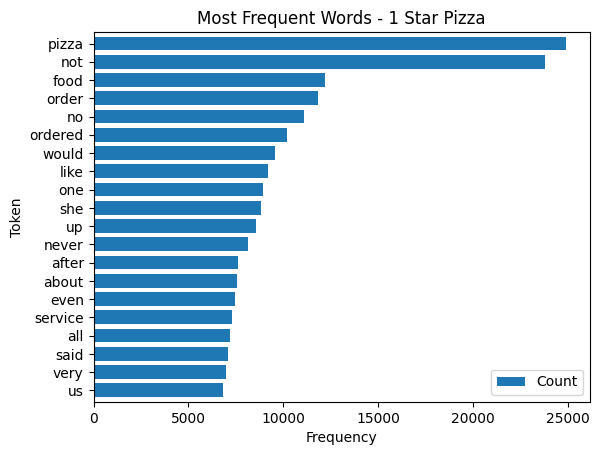

In [ ]:
print('Top Words in 1 Star Pizza Reviews:')
piz1_wc.show()

# Visualize most frequent words
piz1_pd = piz1_wc.toPandas()
barh_plot = piz1_pd.head(20).plot.barh(x = 'Word', y = 'Count',  width = 0.75, title = 'Most Frequent Words - 1 Star Pizza')
barh_plot.invert_yaxis() # Puts largest at top of y axis
barh_plot.set(xlabel = 'Frequency', ylabel = 'Token') # Adds labels

Top Words in 5 Star Pizza Reviews:
+----------+-----+
|      Word|Count|
+----------+-----+
|     pizza|69359|
|     great|38679|
|      food|25644|
|      very|25543|
|      good|23261|
|       not|22981|
|      best|21356|
|       all|19295|
|      love|17767|
|      it's|17164|
|      like|16512|
|   service|16436|
|       one|16398|
|    always|15989|
|    really|14312|
|        go|14059|
|      been|13881|
|     about|12325|
|      back|12105|
|definitely|11379|
+----------+-----+



[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token')]

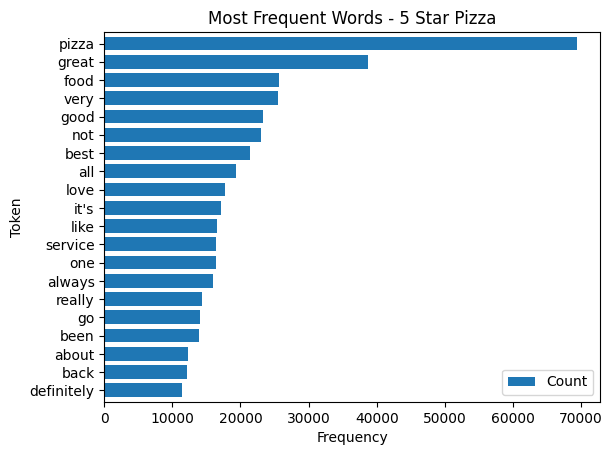

In [ ]:
print('Top Words in 5 Star Pizza Reviews:')
piz5_wc.show()

# Visualize most frequent words
piz5_pd = piz5_wc.toPandas()
barh_plot = piz5_pd.head(20).plot.barh(x = 'Word', y = 'Count',  width = 0.75, title = 'Most Frequent Words - 5 Star Pizza')
barh_plot.invert_yaxis() # Puts largest at top of y axis
barh_plot.set(xlabel = 'Frequency', ylabel = 'Token') # Adds labels

Top Words in 1 Star Mediterranean Reviews:
+----------+-----+
|      Word|Count|
+----------+-----+
|       not| 5506|
|      food| 4024|
|        no| 2169|
|      like| 2159|
|       one| 1931|
|      very| 1823|
|     would| 1790|
|   ordered| 1788|
|        us| 1764|
|       she| 1692|
|      even| 1639|
|   service| 1633|
|     after| 1559|
|       all| 1547|
|        up| 1529|
|     never| 1517|
|        go| 1466|
|     about| 1452|
|restaurant| 1372|
|      came| 1358|
+----------+-----+



[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token')]

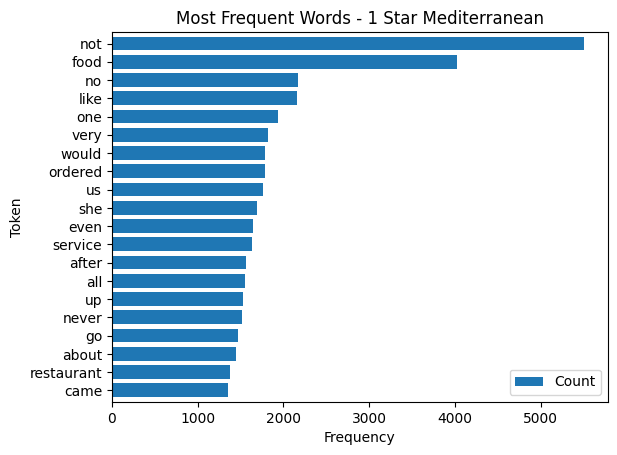

In [ ]:
print('Top Words in 1 Star Mediterranean Reviews:')
med1_wc.show()

# Visualize most frequent words
med1_pd = med1_wc.toPandas()
barh_plot = med1_pd.head(20).plot.barh(x = 'Word', y = 'Count',  width = 0.75, title = 'Most Frequent Words - 1 Star Mediterranean')
barh_plot.invert_yaxis() # Puts largest at top of y axis
barh_plot.set(xlabel = 'Frequency', ylabel = 'Token') # Adds labels

Top Words in 1 Star Mediterranean Reviews:
+----------+-----+
|      Word|Count|
+----------+-----+
|      food|17864|
|     great|13647|
|      very|12618|
|       not| 9155|
|      good| 8043|
|      best| 7978|
|       all| 7849|
|   service| 7209|
|   chicken| 6663|
|      it's| 6508|
|       one| 6498|
|      love| 6212|
|      like| 6130|
|    really| 5935|
|    always| 5840|
|        go| 5693|
|      been| 5657|
|restaurant| 5485|
|     which| 5471|
|definitely| 5167|
+----------+-----+



[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token')]

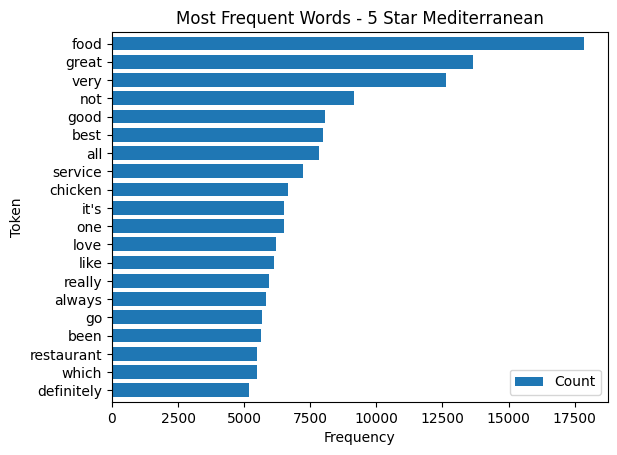

In [ ]:
print('Top Words in 1 Star Mediterranean Reviews:')
med5_wc.show()

# Visualize most frequent words
med5_pd = med5_wc.toPandas()
barh_plot = med5_pd.head(20).plot.barh(x = 'Word', y = 'Count',  width = 0.75, title = 'Most Frequent Words - 5 Star Mediterranean')
barh_plot.invert_yaxis() # Puts largest at top of y axis
barh_plot.set(xlabel = 'Frequency', ylabel = 'Token') # Adds labels

Top Words in 1 Star Deli Reviews:
+--------+-----+
|    Word|Count|
+--------+-----+
|     not| 3904|
|    food| 2071|
|      no| 1742|
|    like| 1599|
|   order| 1506|
|     one| 1506|
|     she| 1498|
|sandwich| 1405|
|   would| 1397|
| ordered| 1308|
|      up| 1305|
|      go| 1274|
|   about| 1227|
|    even| 1213|
|     all| 1213|
|    very| 1191|
|   never| 1153|
|    been| 1152|
|   don't| 1116|
|    back| 1097|
+--------+-----+



[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token')]

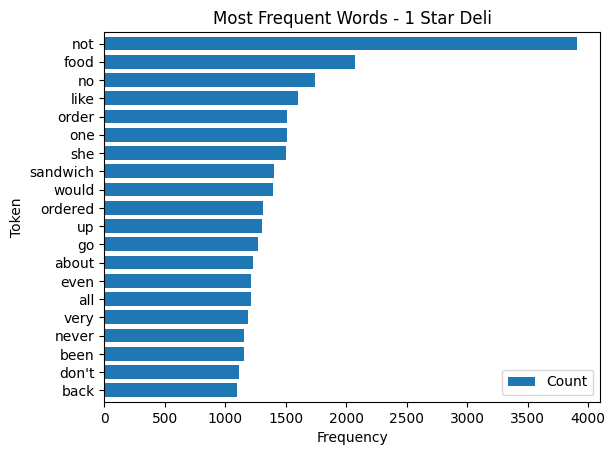

In [ ]:
print('Top Words in 1 Star Deli Reviews:')
del1_wc.show()

# Visualize most frequent words
del1_pd = del1_wc.toPandas()
barh_plot = del1_pd.head(20).plot.barh(x = 'Word', y = 'Count',  width = 0.75, title = 'Most Frequent Words - 1 Star Deli')
barh_plot.invert_yaxis() # Puts largest at top of y axis
barh_plot.set(xlabel = 'Frequency', ylabel = 'Token') # Adds labels

Top Words in 5 Star Deli Reviews:
+--------+-----+
|    Word|Count|
+--------+-----+
|   great| 7828|
|    food| 6079|
|    very| 5499|
|     not| 5285|
|    good| 5011|
|sandwich| 4995|
|     all| 4843|
|    it's| 4640|
|    best| 4638|
|    love| 4491|
|    like| 4433|
|  always| 4053|
|      go| 3916|
|     one| 3829|
|    been| 3422|
|  really| 3148|
|   fresh| 3012|
|   about| 2998|
|    back| 2946|
| service| 2932|
+--------+-----+



[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token')]

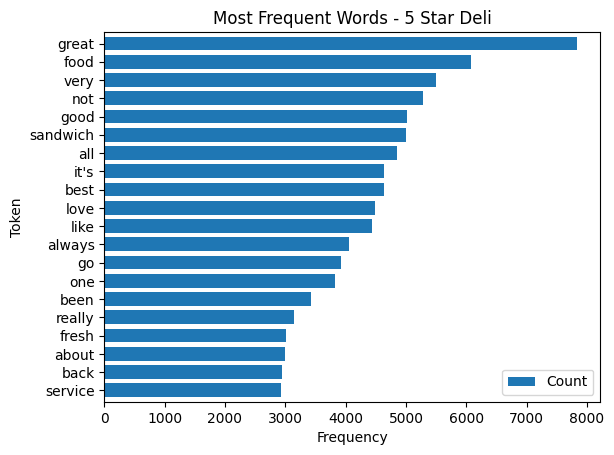

In [ ]:
print('Top Words in 5 Star Deli Reviews:')
del5_wc.show()
# Visualize most frequent words
del5_pd = del5_wc.toPandas()
barh_plot = del5_pd.head(20).plot.barh(x = 'Word', y = 'Count',  width = 0.75, title = 'Most Frequent Words - 5 Star Deli')
barh_plot.invert_yaxis() # Puts largest at top of y axis
barh_plot.set(xlabel = 'Frequency', ylabel = 'Token') # Adds labels

Top Words in 1 Star Sushi Reviews:
+-------+-----+
|   Word|Count|
+-------+-----+
|    not|12405|
|  sushi| 8512|
|   food| 7809|
|     us| 4615|
|   like| 4536|
|    all| 4357|
|    she| 4356|
|     no| 4342|
|service| 4251|
|    one| 4148|
|  would| 3995|
|   even| 3858|
|   very| 3854|
|  never| 3737|
|ordered| 3600|
|  after| 3449|
|  about| 3380|
|   came| 3271|
|  order| 3242|
|     go| 3215|
+-------+-----+



[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token')]

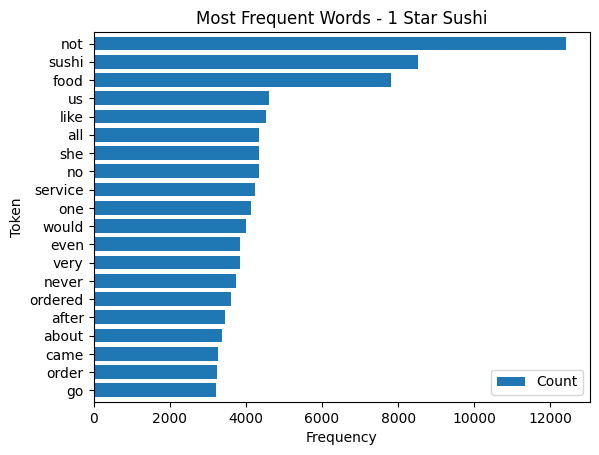

In [ ]:
print('Top Words in 1 Star Sushi Reviews:')
sus1_wc.show()

# Visualize most frequent words
sus1_pd = sus1_wc.toPandas()
barh_plot = sus1_pd.head(20).plot.barh(x = 'Word', y = 'Count',  width = 0.75, title = 'Most Frequent Words - 1 Star Sushi')
barh_plot.invert_yaxis() # Puts largest at top of y axis
barh_plot.set(xlabel = 'Frequency', ylabel = 'Token') # Adds labels

Top Words in 5 Star Sushi Reviews:
+----------+-----+
|      Word|Count|
+----------+-----+
|     sushi|32872|
|     great|17935|
|      very|16155|
|      food|14986|
|       all|12195|
|       not|11695|
|      good|11276|
|   service|10532|
|      best|10280|
|      it's| 8794|
|      love| 8541|
|    always| 8399|
|       one| 8138|
|      like| 7958|
|    really| 7912|
|      been| 7511|
|        go| 7435|
|     fresh| 6904|
|definitely| 6901|
|      roll| 6553|
+----------+-----+



[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token')]

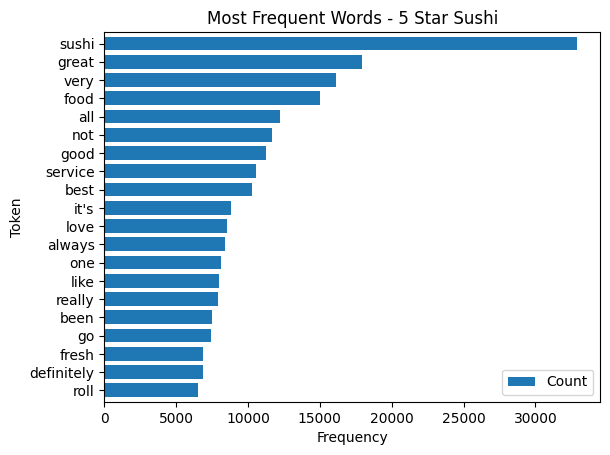

In [ ]:
print('Top Words in 5 Star Sushi Reviews:')
sus5_wc.show()

# Visualize most frequent words
sus5_pd = sus5_wc.toPandas()
barh_plot = sus5_pd.head(20).plot.barh(x = 'Word', y = 'Count',  width = 0.75, title = 'Most Frequent Words - 5 Star Sushi')
barh_plot.invert_yaxis() # Puts largest at top of y axis
barh_plot.set(xlabel = 'Frequency', ylabel = 'Token') # Adds labels

Top Words in 1 Star Car Rental Reviews:
+--------+-----+
|    Word|Count|
+--------+-----+
|     car|12995|
|     not| 8615|
|  rental| 5247|
|      no| 4353|
|   would| 4287|
|      up| 4210|
|    told| 3731|
|    said| 3113|
| service| 3061|
|     all| 3060|
|   never| 3043|
|     one| 2975|
|    rent| 2953|
|      do| 2855|
|customer| 2806|
|    them| 2787|
|     she| 2761|
|      us| 2759|
|   after| 2747|
|   about| 2740|
+--------+-----+



[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token')]

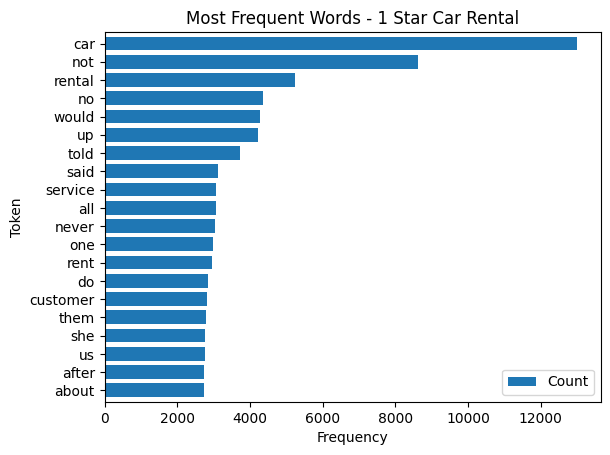

In [ ]:
print('Top Words in 1 Star Car Rental Reviews:')
car1_wc.show()

# Visualize most frequent words
car1_pd = car1_wc.toPandas()
barh_plot = car1_pd.head(20).plot.barh(x = 'Word', y = 'Count',  width = 0.75, title = 'Most Frequent Words - 1 Star Car Rental')
barh_plot.invert_yaxis() # Puts largest at top of y axis
barh_plot.set(xlabel = 'Frequency', ylabel = 'Token') # Adds labels

Top Words in 5 Star Car Rental Reviews:
+----------+-----+
|      Word|Count|
+----------+-----+
|       car| 5678|
|      very| 2367|
|    rental| 2312|
|     great| 2129|
|   service| 1918|
|        up| 1753|
|       all| 1563|
|       not| 1562|
|        no| 1504|
|        us| 1392|
|experience| 1271|
|     would| 1221|
|  customer| 1125|
|     about| 1108|
|    always| 1019|
|      rent| 1016|
|      them|  949|
|       one|  902|
|      back|  871|
|enterprise|  857|
+----------+-----+



[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token')]

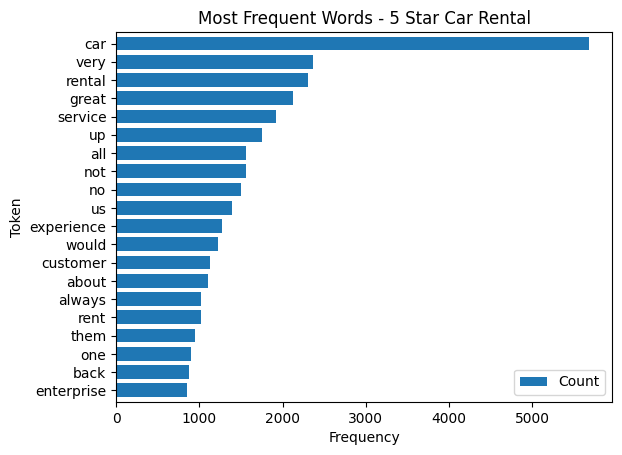

In [ ]:
print('Top Words in 5 Star Car Rental Reviews:')
car5_wc.show()

# Visualize most frequent words
car5_pd = car5_wc.toPandas()
barh_plot = car5_pd.head(20).plot.barh(x = 'Word', y = 'Count',  width = 0.75, title = 'Most Frequent Words - 5 Star Car Rental')
barh_plot.invert_yaxis() # Puts largest at top of y axis
barh_plot.set(xlabel = 'Frequency', ylabel = 'Token') # Adds labels

Top Words in 1 Star Hotel Reviews:
+-----+-----+
| Word|Count|
+-----+-----+
|  not|39760|
| room|37450|
|hotel|24501|
|   no|20213|
|would|17062|
| stay|16737|
|  all|15551|
|  one|14578|
|   up|14124|
|   us|14091|
| like|13095|
|about|11677|
|never|11550|
|  she|11465|
|front|11450|
| even|11396|
| told|11268|
|after|10967|
| very|10894|
| only|10499|
+-----+-----+



[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token')]

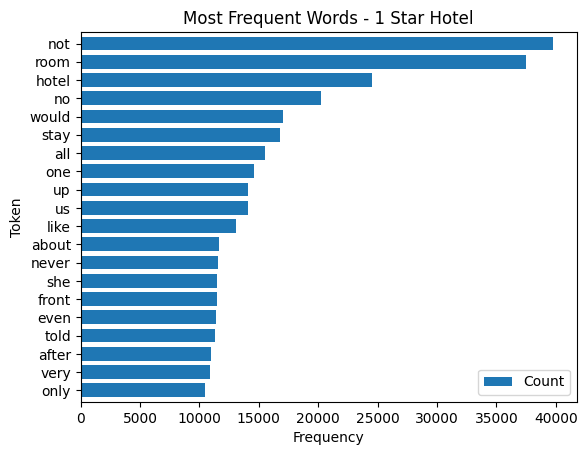

In [ ]:
print('Top Words in 1 Star Hotel Reviews:')
hot1_wc.show()

# Visualize most frequent words
hot1_pd = hot1_wc.toPandas()
barh_plot = hot1_pd.head(20).plot.barh(x = 'Word', y = 'Count',  width = 0.75, title = 'Most Frequent Words - 1 Star Hotel')
barh_plot.invert_yaxis() # Puts largest at top of y axis
barh_plot.set(xlabel = 'Frequency', ylabel = 'Token') # Adds labels

Top Words in 5 Star Hotel Reviews:
+-------+-----+
|   Word|Count|
+-------+-----+
|   room|28668|
|  hotel|27979|
|   very|25672|
|  great|22904|
|    not|18321|
|    all|18095|
|   stay|18029|
|    one|14338|
|   nice|13086|
|   like|12947|
|  staff|12710|
| stayed|12561|
|   it's|12379|
|  rooms|11990|
|service|10546|
|  would|10513|
| really|10427|
|  vegas|10050|
|   pool| 9875|
|     us| 9660|
+-------+-----+



[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token')]

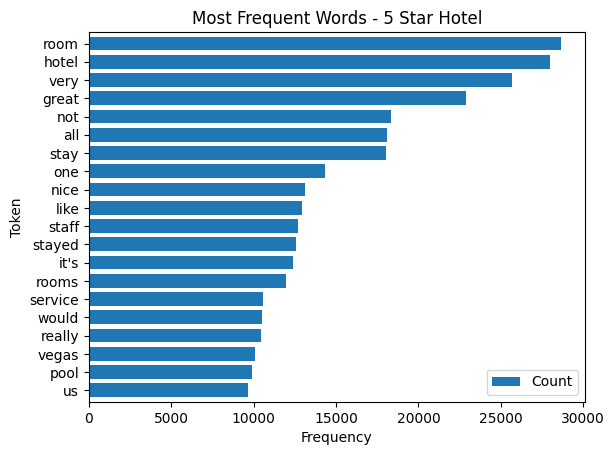

In [ ]:
print('Top Words in 5 Star Hotel Reviews:')
hot5_wc.show()

# Visualize most frequent words
hot5_pd = hot5_wc.toPandas()
barh_plot = hot5_pd.head(20).plot.barh(x = 'Word', y = 'Count',  width = 0.75, title = 'Most Frequent Words - 5 Star Hotel')
barh_plot.invert_yaxis() # Puts largest at top of y axis
barh_plot.set(xlabel = 'Frequency', ylabel = 'Token') # Adds labels

Top Words in 1 Star Casino Reviews:
+-----+-----+
| Word|Count|
+-----+-----+
|  not|24465|
| room|22951|
|hotel|14177|
|   no|12409|
|would|10352|
|  all| 9977|
| stay| 9663|
|   us| 9133|
|  one| 9099|
|   up| 8750|
| like| 8623|
|never| 7583|
|about| 7404|
| even| 7385|
|  she| 7152|
| only| 6898|
| told| 6836|
|after| 6730|
| very| 6594|
| back| 6363|
+-----+-----+



[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token')]

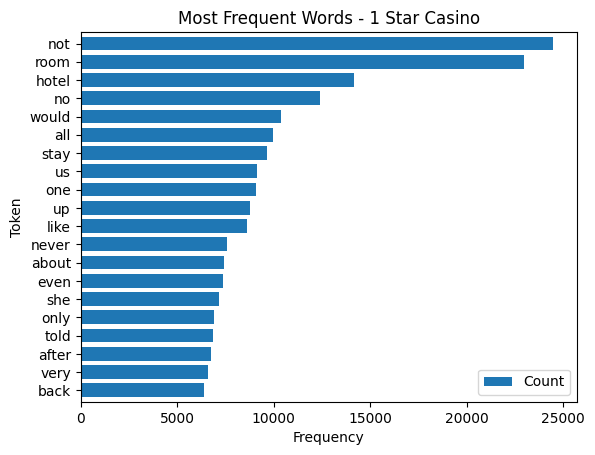

In [ ]:
print('Top Words in 1 Star Casino Reviews:')
cas1_wc.show()

# Visualize most frequent words
cas1_pd = cas1_wc.toPandas()
barh_plot = cas1_pd.head(20).plot.barh(x = 'Word', y = 'Count',  width = 0.75, title = 'Most Frequent Words - 1 Star Casino')
barh_plot.invert_yaxis() # Puts largest at top of y axis
barh_plot.set(xlabel = 'Frequency', ylabel = 'Token') # Adds labels



Top Words in 5 Star Casino Reviews:
+------+-----+
|  Word|Count|
+------+-----+
|  room|14023|
| hotel|12132|
| great|11681|
|  very|11202|
|   all|10062|
|   not| 9923|
|  stay| 8295|
|   one| 7858|
|  like| 7698|
| vegas| 7660|
|  it's| 7489|
|  love| 6200|
|stayed| 6125|
| rooms| 5930|
|  nice| 5879|
|really| 5762|
|casino| 5685|
|  good| 5435|
|  best| 5344|
| about| 5111|
+------+-----+



[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token')]

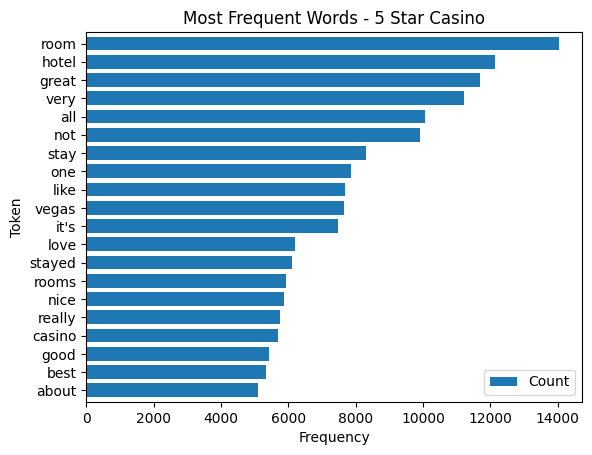

In [ ]:
print('Top Words in 5 Star Casino Reviews:')
cas5_wc.show()

# Visualize most frequent words
cas5_pd = cas5_wc.toPandas()
barh_plot = cas5_pd.head(20).plot.barh(x = 'Word', y = 'Count',  width = 0.75, title = 'Most Frequent Words - 5 Star Casino')
barh_plot.invert_yaxis() # Puts largest at top of y axis
barh_plot.set(xlabel = 'Frequency', ylabel = 'Token') # Adds labels

Top Words in 1 Star Massage Reviews:
+-------+-----+
|   Word|Count|
+-------+-----+
|    not| 3321|
|    she| 3079|
|massage| 2359|
|  would| 1377|
|     no| 1225|
|   back| 1049|
|   like| 1042|
|   told| 1026|
|    one| 1009|
|     up| 1004|
|   very|  973|
|  after|  957|
|  about|  949|
|     do|  944|
|   even|  917|
|    did|  912|
|   said|  897|
|     go|  895|
|  never|  881|
|    all|  870|
+-------+-----+



[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token')]

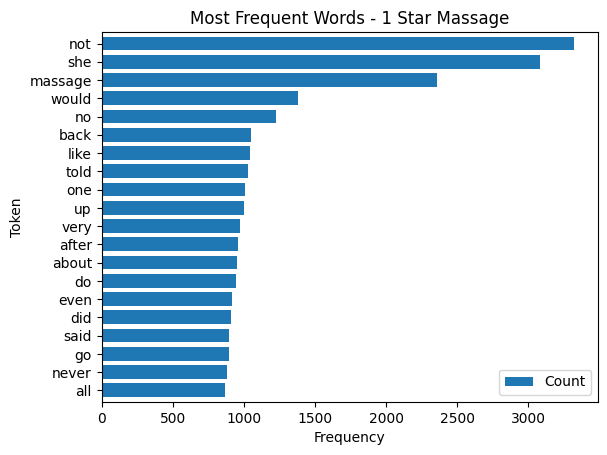

In [ ]:
print('Top Words in 1 Star Massage Reviews:')
mas1_wc.show()

# Visualize most frequent words
mas1_pd = mas1_wc.toPandas()
barh_plot = mas1_pd.head(20).plot.barh(x = 'Word', y = 'Count',  width = 0.75, title = 'Most Frequent Words - 1 Star Massage')
barh_plot.invert_yaxis() # Puts largest at top of y axis
barh_plot.set(xlabel = 'Frequency', ylabel = 'Token') # Adds labels

Top Words in 5 Star Massage  Reviews:
+----------+-----+
|      Word|Count|
+----------+-----+
|       she| 8309|
|   massage| 7535|
|      very| 6250|
|     great| 4427|
|       all| 3545|
|      been| 3540|
|       not| 3396|
|       spa| 3127|
|      back| 3057|
|      hair| 2901|
|      best| 2796|
|      like| 2769|
|    really| 2613|
|     about| 2593|
|        go| 2542|
|       one| 2520|
|     would| 2241|
|     after| 2234|
| recommend| 2180|
|definitely| 2115|
+----------+-----+



[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token')]

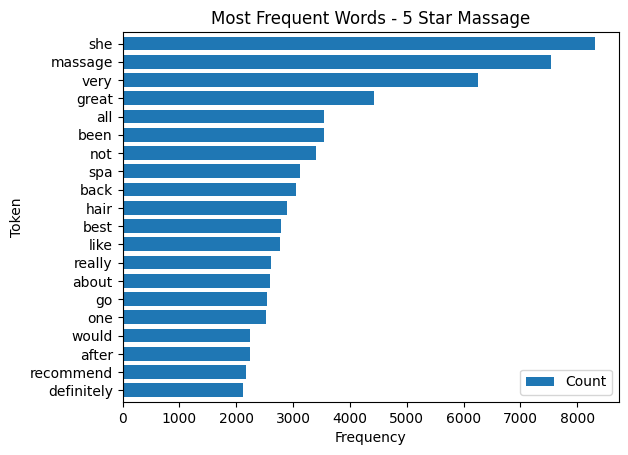

In [ ]:
print('Top Words in 5 Star Massage  Reviews:')
mas5_wc.show()

# Visualize most frequent words
mas5_pd = mas5_wc.toPandas()
barh_plot = mas5_pd.head(20).plot.barh(x = 'Word', y = 'Count',  width = 0.75, title = 'Most Frequent Words - 5 Star Massage')
barh_plot.invert_yaxis() # Puts largest at top of y axis
barh_plot.set(xlabel = 'Frequency', ylabel = 'Token') # Adds labels

Top Words in 1 Star Barber Shop Reviews:
+-------+-----+
|   Word|Count|
+-------+-----+
|   hair| 1802|
|    not| 1487|
|    she| 1431|
|    cut| 1124|
|     up|  692|
|     go|  668|
| barber|  655|
|   like|  637|
|   back|  616|
|    one|  613|
|haircut|  611|
|  would|  601|
|     do|  593|
|     no|  583|
|  asked|  546|
|   even|  541|
|  never|  538|
|    all|  532|
|   told|  514|
| didn't|  514|
+-------+-----+



[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token')]

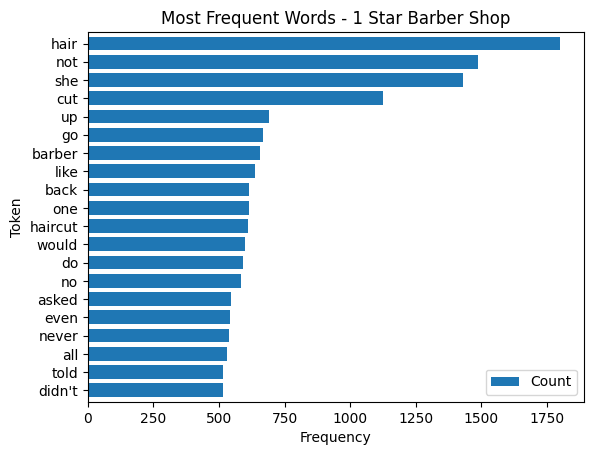

In [ ]:
print('Top Words in 1 Star Barber Shop Reviews:')
bar1_wc.show()

# Visualize most frequent words
bar1_pd = bar1_wc.toPandas()
barh_plot = bar1_pd.head(20).plot.barh(x = 'Word', y = 'Count',  width = 0.75, title = 'Most Frequent Words - 1 Star Barber Shop')
barh_plot.invert_yaxis() # Puts largest at top of y axis
barh_plot.set(xlabel = 'Frequency', ylabel = 'Token') # Adds labels

Top Words in 5 Star Barber Shop Reviews:
+-------+-----+
|   Word|Count|
+-------+-----+
|   hair| 5998|
|  great| 5447|
|    cut| 4378|
| barber| 3886|
|   very| 3378|
|   been| 3356|
|haircut| 2562|
|    she| 2540|
|   best| 2317|
|    his| 2295|
|   good| 2287|
|   shop| 2274|
|    all| 2206|
| always| 2142|
|    not| 2126|
|     go| 1962|
|  about| 1849|
|   like| 1769|
|  going| 1620|
|    did| 1620|
+-------+-----+



[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token')]

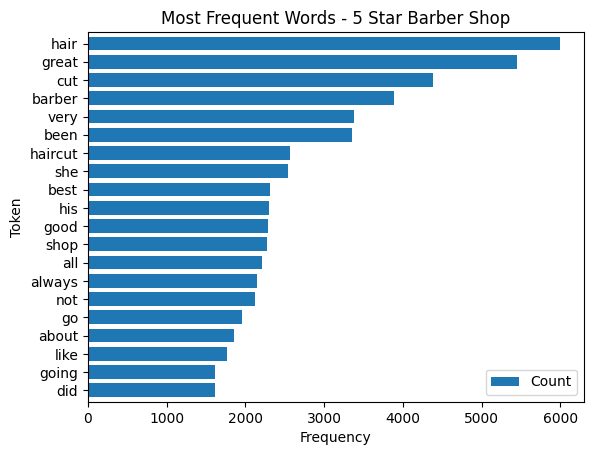

In [ ]:
print('Top Words in 5 Star Barber Shop Reviews:')
bar5_wc.show()

# Visualize most frequent words
bar5_pd = bar5_wc.toPandas()
barh_plot = bar5_pd.head(20).plot.barh(x = 'Word', y = 'Count',  width = 0.75, title = 'Most Frequent Words - 5 Star Barber Shop')
barh_plot.invert_yaxis() # Puts largest at top of y axis
barh_plot.set(xlabel = 'Frequency', ylabel = 'Token') # Adds labels

Top Words in 1 Star Hair Salon Reviews:
+-----+-----+
| Word|Count|
+-----+-----+
|  she|10787|
| hair| 8828|
|  not| 7660|
|would| 3368|
|  cut| 3028|
|   do| 2912|
| like| 2794|
|   no| 2765|
| told| 2710|
|   up| 2697|
|   go| 2684|
|  did| 2616|
|about| 2581|
| back| 2546|
| even| 2468|
|  one| 2430|
| very| 2383|
|salon| 2358|
|  all| 2349|
|never| 2330|
+-----+-----+



[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token')]

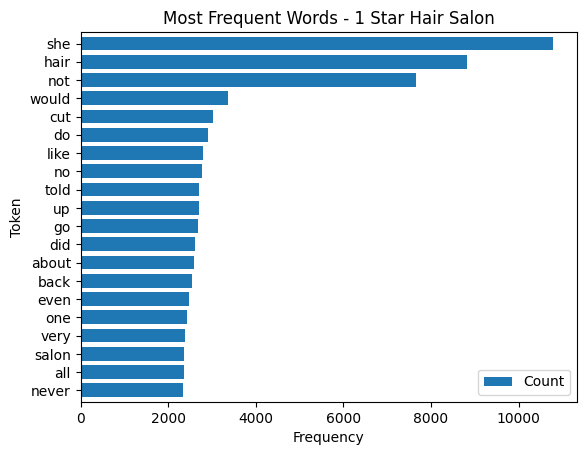

In [ ]:
print('Top Words in 1 Star Hair Salon Reviews:')
sal1_wc.show()

# Visualize most frequent words
sal1_pd = sal1_wc.toPandas()
barh_plot = sal1_pd.head(20).plot.barh(x = 'Word', y = 'Count',  width = 0.75, title = 'Most Frequent Words - 1 Star Hair Salon')
barh_plot.invert_yaxis() # Puts largest at top of y axis
barh_plot.set(xlabel = 'Frequency', ylabel = 'Token') # Adds labels

Top Words in 5 Star Hair Salon Reviews:
+------+-----+
|  Word|Count|
+------+-----+
|  hair|31434|
|   she|28952|
|  very|13888|
| great|13701|
| salon|10773|
|  been|10715|
|   cut| 9940|
|   not| 8775|
|   all| 8229|
|always| 7793|
|   did| 7727|
| about| 7588|
|  love| 7075|
|    go| 6909|
|really| 6770|
|  like| 6518|
|  best| 6129|
| going| 5882|
| would| 5795|
|    do| 5662|
+------+-----+



[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token')]

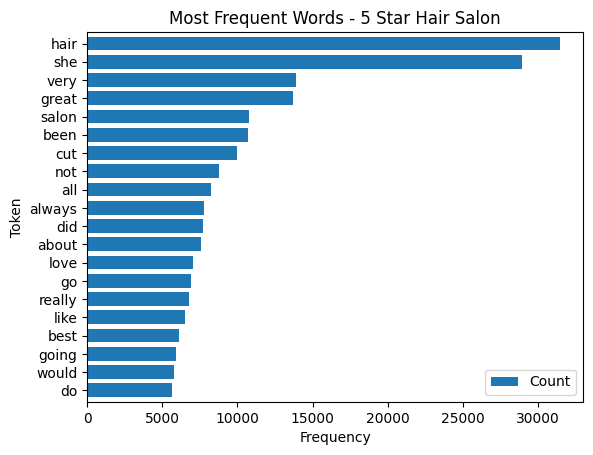

In [ ]:
print('Top Words in 5 Star Hair Salon Reviews:')
sal5_wc.show()

# Visualize most frequent words
sal5_pd = sal5_wc.toPandas()
barh_plot = sal5_pd.head(20).plot.barh(x = 'Word', y = 'Count',  width = 0.75, title = 'Most Frequent Words - 5 Star Hair Salon')
barh_plot.invert_yaxis() # Puts largest at top of y axis
barh_plot.set(xlabel = 'Frequency', ylabel = 'Token') # Adds labels

Top Words in 1 Star Tattoo Parlor Reviews:
+------+-----+
|  Word|Count|
+------+-----+
|   not|  836|
|tattoo|  785|
|   she|  474|
|    do|  381|
|    up|  372|
| would|  360|
|    go|  326|
| about|  316|
|  told|  298|
|  said|  297|
|  like|  294|
|  even|  286|
|  back|  285|
|   did|  276|
|    no|  270|
|   his|  266|
| after|  262|
|   all|  261|
|   one|  255|
|  very|  254|
+------+-----+



[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token')]

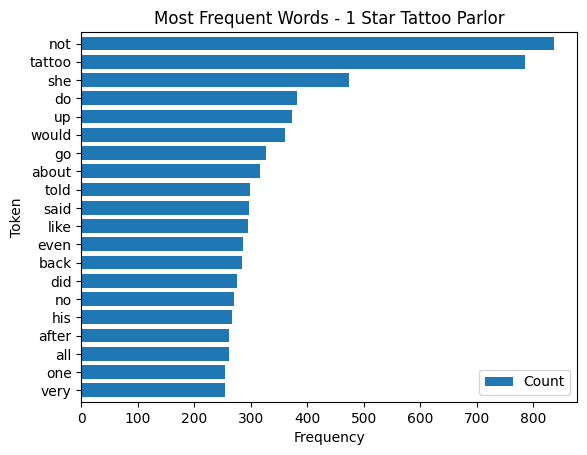

In [ ]:
print('Top Words in 1 Star Tattoo Parlor Reviews:')
tat1_wc.show()

# Visualize most frequent words
tat1_pd = tat1_wc.toPandas()
barh_plot = tat1_pd.head(20).plot.barh(x = 'Word', y = 'Count',  width = 0.75, title = 'Most Frequent Words - 1 Star Tattoo Parlor')
barh_plot.invert_yaxis() # Puts largest at top of y axis
barh_plot.set(xlabel = 'Frequency', ylabel = 'Token') # Adds labels

Top Words in 5 Star Tattoo Parlor Reviews:
+---------+-----+
|     Word|Count|
+---------+-----+
|   tattoo| 4484|
|     very| 3421|
|    great| 2500|
|      she| 2276|
|     shop| 2010|
|      all| 1970|
|     work| 1955|
|      did| 1747|
|     done| 1645|
|     back| 1644|
|    about| 1627|
|      his| 1617|
|      not| 1522|
|       go| 1473|
|    first| 1459|
|    would| 1386|
|       up| 1373|
|recommend| 1364|
|     been| 1285|
|   really| 1262|
+---------+-----+



[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token')]

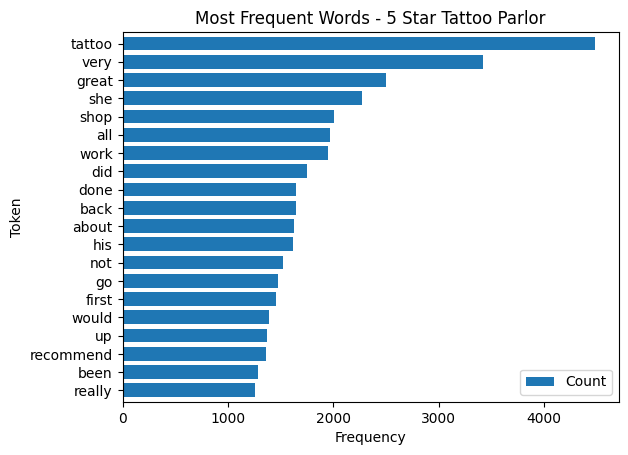

In [ ]:
print('Top Words in 5 Star Tattoo Parlor Reviews:')
tat5_wc.show()

# Visualize most frequent words
tat5_pd = tat5_wc.toPandas()
barh_plot = tat5_pd.head(20).plot.barh(x = 'Word', y = 'Count',  width = 0.75, title = 'Most Frequent Words - 5 Star Tattoo Parlor')
barh_plot.invert_yaxis() # Puts largest at top of y axis
barh_plot.set(xlabel = 'Frequency', ylabel = 'Token') # Adds labels

# Pyspark Streaming

In [ ]:
# Define Yelp API parameters
api_key = "THxFAzQF7CfFGub-S1rC9m98T3cAnWbmcRes5QbNitv0a_RtlXv-DyHokHtxhfNz5jRIJklCTkOsL79r2azmrlAH0rOzcNdqr8txmIsdO8YVh3qEkSc_yE3y0zVEZHYx"
headers = {'Authorization': 'Bearer %s' % api_key}
params = {'limit': 5, 'sort_by': 'date_desc'}

In [ ]:
# Get top 50 Business_IDS based on reviews for review streaming
bus_id_list_df = top_businesses_df.limit(50)
bus_id_list = bus_id_list_df.select(col("first(business_id)")).rdd.flatMap(lambda x: x).collect()


In [ ]:
bus_id_list

['hsObd_dRmpxNGmXjwSYuHg',
 'l2M67j_7O0fOJiE28yaREA',
 'Absr2Yz1vKZgBvyOh--9tQ',
 'y0m8WqajagGgZXnMEhMzfQ',
 'MrZP-KskDvvFvieam_mVTQ',
 'PHb9AgEVXzuV4ETl3w5onQ',
 'ySvnHM-7yiql4p72h1plyg',
 'j6Pjn7vmWvQPIPHBizbD_w',
 'hjUTVItTU5pb3rs2Y9iqkQ',
 '65lsX6xUM8zDG6YKoNn5hA',
 '2hIOkf1KqQpQBBr1FHoKuQ',
 'OuCpUWeKcGbNsGix9N6zpg',
 'TwbTw37N1NluGNthAGl59w',
 '1OhW3wUWcwPsjo1PnBufZw',
 'iYQPfLcPQXiYi-kycrm2rw',
 '_h1Vkj_kysFo-CFrEHlsCg',
 '4TnxVgLwes8XfWhPs0loUQ',
 'KizIjjPp_XRNA21aHU-eow',
 'ohGaxI7vLlEqN1H0GYlFUA',
 'LcSAHDSZI_IX86NLxMPoQA',
 'VUrBExjDoBpNURe_tfXEXw',
 'gvwjeY9iARJ8a7in4jJxvg',
 'BpAxZmy45l20j-WQWBGKng',
 'NDpZYXuqMDxyuu4lj7m78Q',
 '03A87_FA1-J2D43G0pCZhA',
 'H57kJV5TUpYyQrY0NvoWYw',
 'uW0BNMXEO7fir8RNetxibA',
 '7FsHVPrgJHMKA8x3tZMM-g',
 'JjA9YGxiQ_igfM7IWzGryg',
 'jg7aqcmbI5XdjGLZwWNcHg',
 'dc7IV_UFZPXJTiJ8v6Djhg',
 'cjLf6ijfBz1WcsI3WEr-ww',
 'GmCDA8T9sgBvHvN8vTMOdQ',
 'pwOhoa7H4xF2cSh6OFpdrQ',
 '4r0Ho5rbAZ_BhXvpQmxbag',
 'IPcYWUkFDWCV-l9Z9gqZdg',
 'hx-Thk_Tr6lq-qr5li1m4g',
 

In [ ]:
# Sparksession
spark = SparkSession.builder.appName("Yelp_Review_Live").getOrCreate()

# Business Id list For in-class DEMO
# bus_id_list = [
# '4LP1fINwJGhLXF2dWxz5nw',
# 'bMSiHjs2fbKbBNPyuTwhHA',
# 'c_P-PDv_1omKKKmeCJxG8w',
# 'f8IMQgRwo-8GP372MElDGQ',
# 'CMhcVDLjmLOQhoO2gESXcw',
# 'MYB1ZMspBk1Xc_awp_PtSw',
# 'GqGVAE3kbEW46FU1LydVUg',
# 'ajoqEHnCZTD8-8GqGLq9-Q',
# "4IdcT63iE5fNrVzayZtKEw",
# 'aPAljlYaHdDDKZngS5I2UQ',
# 'ii8sAGBexBOJoYRFafF9XQ',
# 'R6dsQhkBRq2qwwPnqommKw']


# Only inputs one list at a time in url request
business_id = bus_id_list[0]

# Schema for reviews
reviewSchema = StructType([
    StructField("id", StringType(), True),
    StructField("Business_Id", StringType(), True),
    StructField("rating", IntegerType(), True),
    StructField("time_created", StringType(), True),
    StructField("text", StringType(), True),
    StructField("user", StructType([
        StructField("id", StringType(), True),
        StructField("profile_url", StringType(), True),
        StructField("image_url", StringType(), True),
        StructField("name", StringType(), True)
    ]))
])


# Output DataFrame
yelp_top_bus_streaming = spark.createDataFrame([], schema=reviewSchema)



# while True:
for i, business_id in enumerate(bus_id_list):
    # API Request
    url = 'https://api.yelp.com/v3/businesses/%s/reviews' % business_id
    print(f"Loop {i}: {url}")
    try:
      response = requests.get(url, headers=headers, params=params)
      response.raise_for_status()
    except requests.exceptions.HTTPError as e:
      print(f"Error fetching reviews for business ID {business_id}: {e}")
      continue
    print(response.content)
    reviews = response.json()

    # Reviews to Spark DataFrame
    stream_df = spark.createDataFrame(reviews["reviews"], schema=reviewSchema)

    # Adds business_id column
    stream_df = stream_df.withColumn("business_id", lit(business_id))

    # Appends DataFrame to output DataFrame for reviews concatination
    yelp_top_bus_streaming = yelp_top_bus_streaming.union(stream_df)

    # Show the output DataFrame
    yelp_top_bus_streaming.show()

# Wait in seconds before next api request, only use this and while statement if waiting for new request
  # time.sleep(20)





Loop 0: https://api.yelp.com/v3/businesses/hsObd_dRmpxNGmXjwSYuHg/reviews
b'{"reviews": [{"id": "ekU3fckJuttbpBaaGrtK3Q", "url": "https://www.yelp.com/biz/angel-hotel-whitby?adjust_creative=PqiETB3mwc_Bdi--YjeyGg&hrid=ekU3fckJuttbpBaaGrtK3Q&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=PqiETB3mwc_Bdi--YjeyGg", "text": "Love a spoons however, after a recent visit with my party of 11 including my elderly mother and 5 children aged 8 - 14, service was atrocious missing 3 of...", "rating": 1, "time_created": "2017-08-01 13:42:24", "user": {"id": "9thViNJWVyEw2h2xObpl_g", "profile_url": "https://www.yelp.com/user_details?userid=9thViNJWVyEw2h2xObpl_g", "image_url": "https://s3-media3.fl.yelpcdn.com/photo/cfG5bmASA0Jas1ZD8HZUNA/o.jpg", "name": "Judith L."}}, {"id": "BRzjTUihuIXBBvQoVWwvxg", "url": "https://www.yelp.com/biz/angel-hotel-whitby?adjust_creative=PqiETB3mwc_Bdi--YjeyGg&hrid=BRzjTUihuIXBBvQoVWwvxg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&

In [ ]:
# User information to new columns and column renaming / dropping
yelp_top_bus_streaming = yelp_top_bus_streaming.withColumn("user_id", yelp_top_bus_streaming["user"]["id"])
yelp_top_bus_streaming = yelp_top_bus_streaming.withColumn("user_fullname", yelp_top_bus_streaming["user"]["name"])
yelp_top_bus_streaming = yelp_top_bus_streaming.drop("user")
yelp_top_bus_streaming = yelp_top_bus_streaming.withColumnRenamed("id","Review_Id")
yelp_top_bus_streaming = yelp_top_bus_streaming.withColumnRenamed("rating","Review_Rating")
yelp_top_bus_streaming = yelp_top_bus_streaming.withColumnRenamed("time_created","Review_Created_Time")
yelp_top_bus_streaming = yelp_top_bus_streaming.withColumnRenamed("text","Review_Text")

In [ ]:
yelp_top_bus_streaming.show()

+--------------------+--------------------+-------------+-------------------+--------------------+--------------------+---------------+
|           Review_Id|         Business_Id|Review_Rating|Review_Created_Time|         Review_Text|             user_id|  user_fullname|
+--------------------+--------------------+-------------+-------------------+--------------------+--------------------+---------------+
|ekU3fckJuttbpBaaG...|hsObd_dRmpxNGmXjw...|            1|2017-08-01 13:42:24|Love a spoons how...|9thViNJWVyEw2h2xO...|      Judith L.|
|BRzjTUihuIXBBvQoV...|hsObd_dRmpxNGmXjw...|            1|2015-07-15 11:35:29|Very disappointed...|0LwY1-3ibbIYtN_lW...|        Paul H.|
|n_yaeCHTXvQY-mBJg...|hsObd_dRmpxNGmXjw...|            5|2013-07-15 06:15:12|Last week we stay...|Y65V2irC1xFUzgh0i...|         Garylc|
|wt4n_jrayPnBVrmdl...|l2M67j_7O0fOJiE28...|            5|2009-01-21 11:15:12|If you want a tre...|FftQU1e3KNTXFhK2S...|         quacks|
|_AYL_l55fmhnHe-sI...|l2M67j_7O0fOJiE28...|     

# PySpark Streaming Sentiment Analysis

In [ ]:
# sentiment polarity using TextBlob
def get_sentiment(text):
  blob = TextBlob(text)
                  #, analyzer=NaiveBayesAnalyzer())

  sentiment = blob.sentiment.polarity
  return sentiment

# UDF to use with PySpark dataframe
sentiment_udf = udf(get_sentiment, StringType())

# apply sentiment analysis function to the Review_Text
yelp_top_bus_streaming = yelp_top_bus_streaming.withColumn("Sentiment", sentiment_udf("Review_Text"))

# Creates an Average of Sentiment and Review_Rating columns
yelp_top_bus_streaming = yelp_top_bus_streaming.withColumn("Sent_Rat_Avg", (yelp_top_bus_streaming["Review_Rating"] + yelp_top_bus_streaming["Sentiment"])/2)

# classify the Review based on the Sent_Rat_Avg threshold
positive_threshold = 2
negative_threshold = 1
yelp_top_bus_streaming = yelp_top_bus_streaming.withColumn("Sentiment_Category", \
                  F.when(F.col("Sent_Rat_Avg") > positive_threshold, "Positive") \
                  .when(F.col("Sent_Rat_Avg") < negative_threshold, "Negative") \
                  .otherwise("Neutral"))




In [ ]:
yelp_top_bus_streaming.show()

+--------------------+--------------------+-------------+-------------------+--------------------+--------------------+---------------+--------------------+------------------+------------------+
|           Review_Id|         Business_Id|Review_Rating|Review_Created_Time|         Review_Text|             user_id|  user_fullname|           Sentiment|      Sent_Rat_Avg|Sentiment_Category|
+--------------------+--------------------+-------------+-------------------+--------------------+--------------------+---------------+--------------------+------------------+------------------+
|ekU3fckJuttbpBaaG...|hsObd_dRmpxNGmXjw...|            1|2017-08-01 13:42:24|Love a spoons how...|9thViNJWVyEw2h2xO...|      Judith L.|-0.09999999999999999|              0.45|          Negative|
|BRzjTUihuIXBBvQoV...|hsObd_dRmpxNGmXjw...|            1|2015-07-15 11:35:29|Very disappointed...|0LwY1-3ibbIYtN_lW...|        Paul H.| -0.3583333333333334|0.3208333333333333|          Negative|
|n_yaeCHTXvQY-mBJg...|hsO

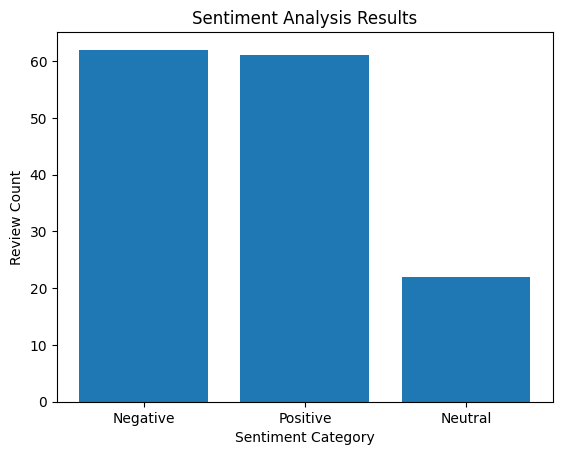

In [ ]:
# Count and group by sentiment category
sentiment_counts = yelp_top_bus_streaming.groupBy("Sentiment_Category").count().collect()

# from pyspark to pandas df
sentiment_counts_df = pd.DataFrame(sentiment_counts, columns=["Sentiment_Category", "count"])

# plot the sentiment counts as a bar graph
plt.bar(sentiment_counts_df["Sentiment_Category"], sentiment_counts_df["count"])
plt.title("Sentiment Analysis Results")
plt.xlabel("Sentiment Category")
plt.ylabel("Review Count")
plt.show()